In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
from xgboost import XGBClassifier


# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set visualization style
plt.style.use('seaborn')
sns.set_style("whitegrid")


In [34]:

#for EDA
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Load separate copies for modeling
train_df_model = pd.read_csv('train_data.csv')
test_df_model = pd.read_csv('test_data.csv')
sample_submission = pd.read_csv('sample_submission.csv')

/var/folders/b9/bmsjjm2x30vcw342sbqf10xw0000gn/T/ipykernel_26735/2166384418.py:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('train_data.csv')
/var/folders/b9/bmsjjm2x30vcw342sbqf10xw0000gn/T/ipykernel_26735/2166384418.py:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df_model = pd.read_csv('train_data.csv')


In [3]:
# Check missing values in target
print("\nMissing values in Claim Injury Type:", train_df['Claim Injury Type'].isnull().sum())
print("Total rows:", len(train_df))
print("Percentage missing:", (train_df['Claim Injury Type'].isnull().sum() / len(train_df)) * 100)


Missing values in Claim Injury Type: 19445
Total rows: 593471
Percentage missing: 3.276486972404717


In [4]:
train_df = train_df.dropna(subset=['Claim Injury Type']).reset_index(drop=True)

In [5]:
# Initial processing of target variable
train_df['Claim Injury Type'] = train_df['Claim Injury Type'].astype(str)
train_df['Claim Injury Type Num'] = train_df['Claim Injury Type'].str.extract('^(\d+)').astype(int)

In [6]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (574026, 34)
Test shape: (387975, 30)


In [7]:
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)
print("\nColumns only in train:", train_cols - test_cols)
print("Columns only in test:", test_cols - train_cols)



Columns only in train: {'Claim Injury Type Num', 'Claim Injury Type', 'WCB Decision', 'Agreement Reached'}
Columns only in test: set()


In [8]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574026 entries, 0 to 574025
Data columns (total 34 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       574026 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [9]:
train_df.describe()


Age at Injury  Average Weekly Wage     Birth Year  Claim Identifier  \
count  574026.000000         5.453750e+05  544948.000000      5.740260e+05   
mean       42.114270         4.910883e+02    1886.767604      5.778956e+06   
std        14.256432         6.092918e+03     414.644423      2.223082e+05   
min         0.000000         0.000000e+00       0.000000      5.393066e+06   
25%        31.000000         0.000000e+00    1965.000000      5.586764e+06   
50%        42.000000         0.000000e+00    1977.000000      5.778282e+06   
75%        54.000000         8.410000e+02    1989.000000      5.971329e+06   
max       117.000000         2.828079e+06    2018.000000      6.165685e+06   

         IME-4 Count  Industry Code  OIICS Nature of Injury Description  \
count  132803.000000  564068.000000                                 0.0   
mean        3.207337      58.645305                                 NaN   
std         2.832303      19.644175                                 NaN   
min         1.000000      11.000000                                 NaN   
25%         1.000000      45.000000                                 NaN   
50%         2.000000      61.000000                                 NaN   
75%         4.000000      71.000000                                 NaN   
max        73.000000      92.000000                                 NaN   

       WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
count              558386.000000               558369.000000   
mean                   54.381143                   41.013839   
std                    25.874281                   22.207521   
min                     1.000000                    1.000000   
25%                    31.000000                   16.000000   
50%                    56.000000                   49.000000   
75%                    75.000000                   52.000000   
max                    99.000000                   91.000000   

       WCIO Part Of Body Code  Agreement Reached  Number of Dependents  \
count           556944.000000      574026.000000         574026.000000   
mean                39.738146           0.046665              3.006559   
std                 22.365940           0.210921              2.000801   
min                 -9.000000           0.000000              0.000000   
25%                 33.000000           0.000000              1.000000   
50%                 38.000000           0.000000              3.000000   
75%                 53.000000           0.000000              5.000000   
max                 99.000000           1.000000              6.000000   

       Claim Injury Type Num  
count          574026.000000  
mean                2.903151  
std                 1.126493  
min                 1.000000  
25%                 2.000000  
50%                 2.000000  
75%                 4.000000  
max                 8.000000

In [10]:
target_counts = train_df['Claim Injury Type Num'].value_counts().sort_index()
print("\nTarget Distribution:")
print(target_counts)


Target Distribution:
1     12477
2    291078
3     68906
4    148507
5     48280
6      4211
7        97
8       470
Name: Claim Injury Type Num, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8')])

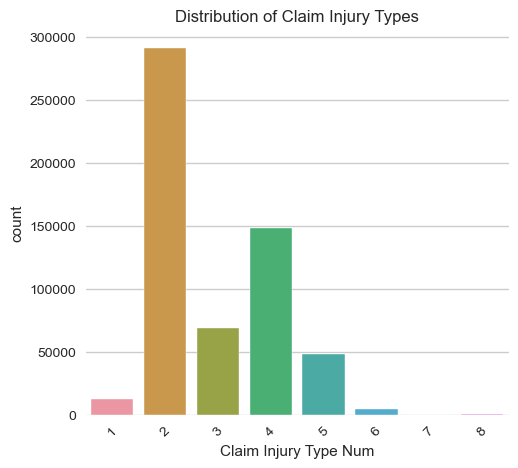

In [11]:
plt.figure(figsize=(12, 5))

# Count plot
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='Claim Injury Type Num')
plt.title('Distribution of Claim Injury Types')
plt.xticks(rotation=45)


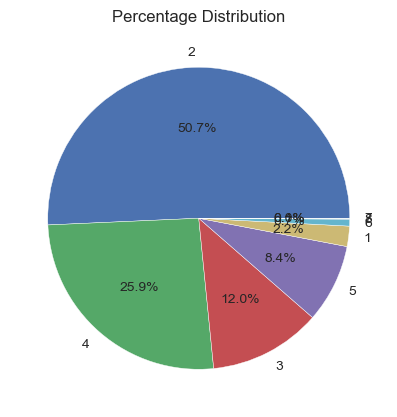

In [12]:
plt.subplot(1, 2, 2)
target_percentages = (train_df['Claim Injury Type Num'].value_counts() / len(train_df)) * 100
plt.pie(target_percentages, labels=target_percentages.index, autopct='%1.1f%%')
plt.title('Percentage Distribution')

plt.tight_layout()
plt.show()

In [14]:
def analyze_missing_values(df, name="Dataset"):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_stats = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    missing_stats = missing_stats[missing_stats['Missing Values'] > 0].sort_values('Percentage', ascending=False)
    
    print(f"\nMissing Values in {name}:")
    print(missing_stats)
    
    return missing_stats

In [15]:
train_missing = analyze_missing_values(train_df, "Training Set")
test_missing = analyze_missing_values(test_df, "Test Set")

# Visualize missing values
plt.figure(figsize=(15, 5))



Missing Values in Training Set:
                                    Missing Values  Percentage
OIICS Nature of Injury Description          574026  100.000000
IME-4 Count                                 441223   76.864637
First Hearing Date                          423228   73.729761
C-3 Date                                    386781   67.380397
Birth Year                                   29078    5.065624
Average Weekly Wage                          28651    4.991237
Zip Code                                     28637    4.988798
WCIO Part Of Body Code                       17082    2.975823
WCIO Part Of Body Description                17082    2.975823
WCIO Nature of Injury Code                   15657    2.727577
WCIO Nature of Injury Description            15657    2.727577
WCIO Cause of Injury Code                    15640    2.724615
WCIO Cause of Injury Description             15640    2.724615
C-2 Date                                     14560    2.536470
Industry Code Descript

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0, 0.5, 'Percentage Missing')

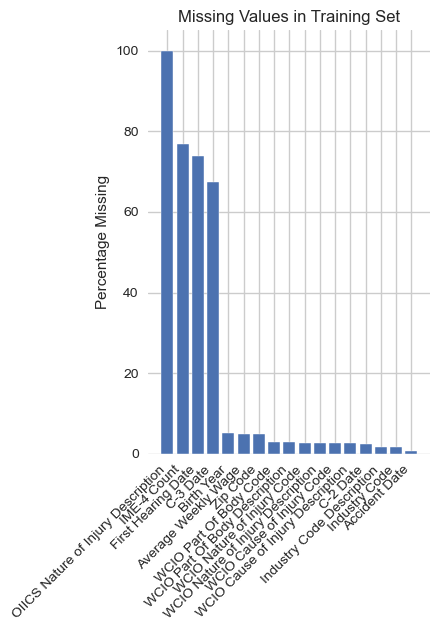

In [16]:
plt.subplot(1, 2, 1)
plt.bar(range(len(train_missing)), train_missing['Percentage'])
plt.title('Missing Values in Training Set')
plt.xticks(range(len(train_missing)), train_missing.index, rotation=45, ha='right')
plt.ylabel('Percentage Missing')

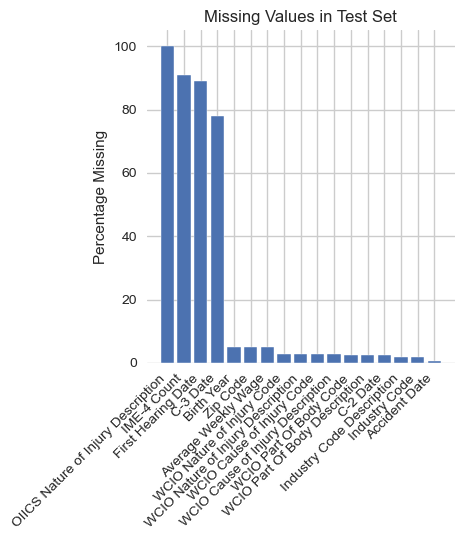

In [17]:
plt.subplot(1, 2, 2)
plt.bar(range(len(test_missing)), test_missing['Percentage'])
plt.title('Missing Values in Test Set')
plt.xticks(range(len(test_missing)), test_missing.index, rotation=45, ha='right')
plt.ylabel('Percentage Missing')

plt.tight_layout()
plt.show()

In [18]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols 
               if col not in ['Claim Injury Type Num', 'Claim Identifier']]

# Basic statistics for numeric columns
numeric_stats = train_df[numeric_cols].describe()
print("Numeric Features Statistics:")
display(numeric_stats)

Numeric Features Statistics:


Age at Injury  Average Weekly Wage     Birth Year    IME-4 Count  \
count  574026.000000         5.453750e+05  544948.000000  132803.000000   
mean       42.114270         4.910883e+02    1886.767604       3.207337   
std        14.256432         6.092918e+03     414.644423       2.832303   
min         0.000000         0.000000e+00       0.000000       1.000000   
25%        31.000000         0.000000e+00    1965.000000       1.000000   
50%        42.000000         0.000000e+00    1977.000000       2.000000   
75%        54.000000         8.410000e+02    1989.000000       4.000000   
max       117.000000         2.828079e+06    2018.000000      73.000000   

       Industry Code  OIICS Nature of Injury Description  \
count  564068.000000                                 0.0   
mean       58.645305                                 NaN   
std        19.644175                                 NaN   
min        11.000000                                 NaN   
25%        45.000000                                 NaN   
50%        61.000000                                 NaN   
75%        71.000000                                 NaN   
max        92.000000                                 NaN   

       WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
count              558386.000000               558369.000000   
mean                   54.381143                   41.013839   
std                    25.874281                   22.207521   
min                     1.000000                    1.000000   
25%                    31.000000                   16.000000   
50%                    56.000000                   49.000000   
75%                    75.000000                   52.000000   
max                    99.000000                   91.000000   

       WCIO Part Of Body Code  Agreement Reached  Number of Dependents  
count           556944.000000      574026.000000         574026.000000  
mean                39.738146           0.046665              3.006559  
std                 22.365940           0.210921              2.000801  
min                 -9.000000           0.000000              0.000000  
25%                 33.000000           0.000000              1.000000  
50%                 38.000000           0.000000              3.000000  
75%                 53.000000           0.000000              5.000000  
max                 99.000000           1.000000              6.000000

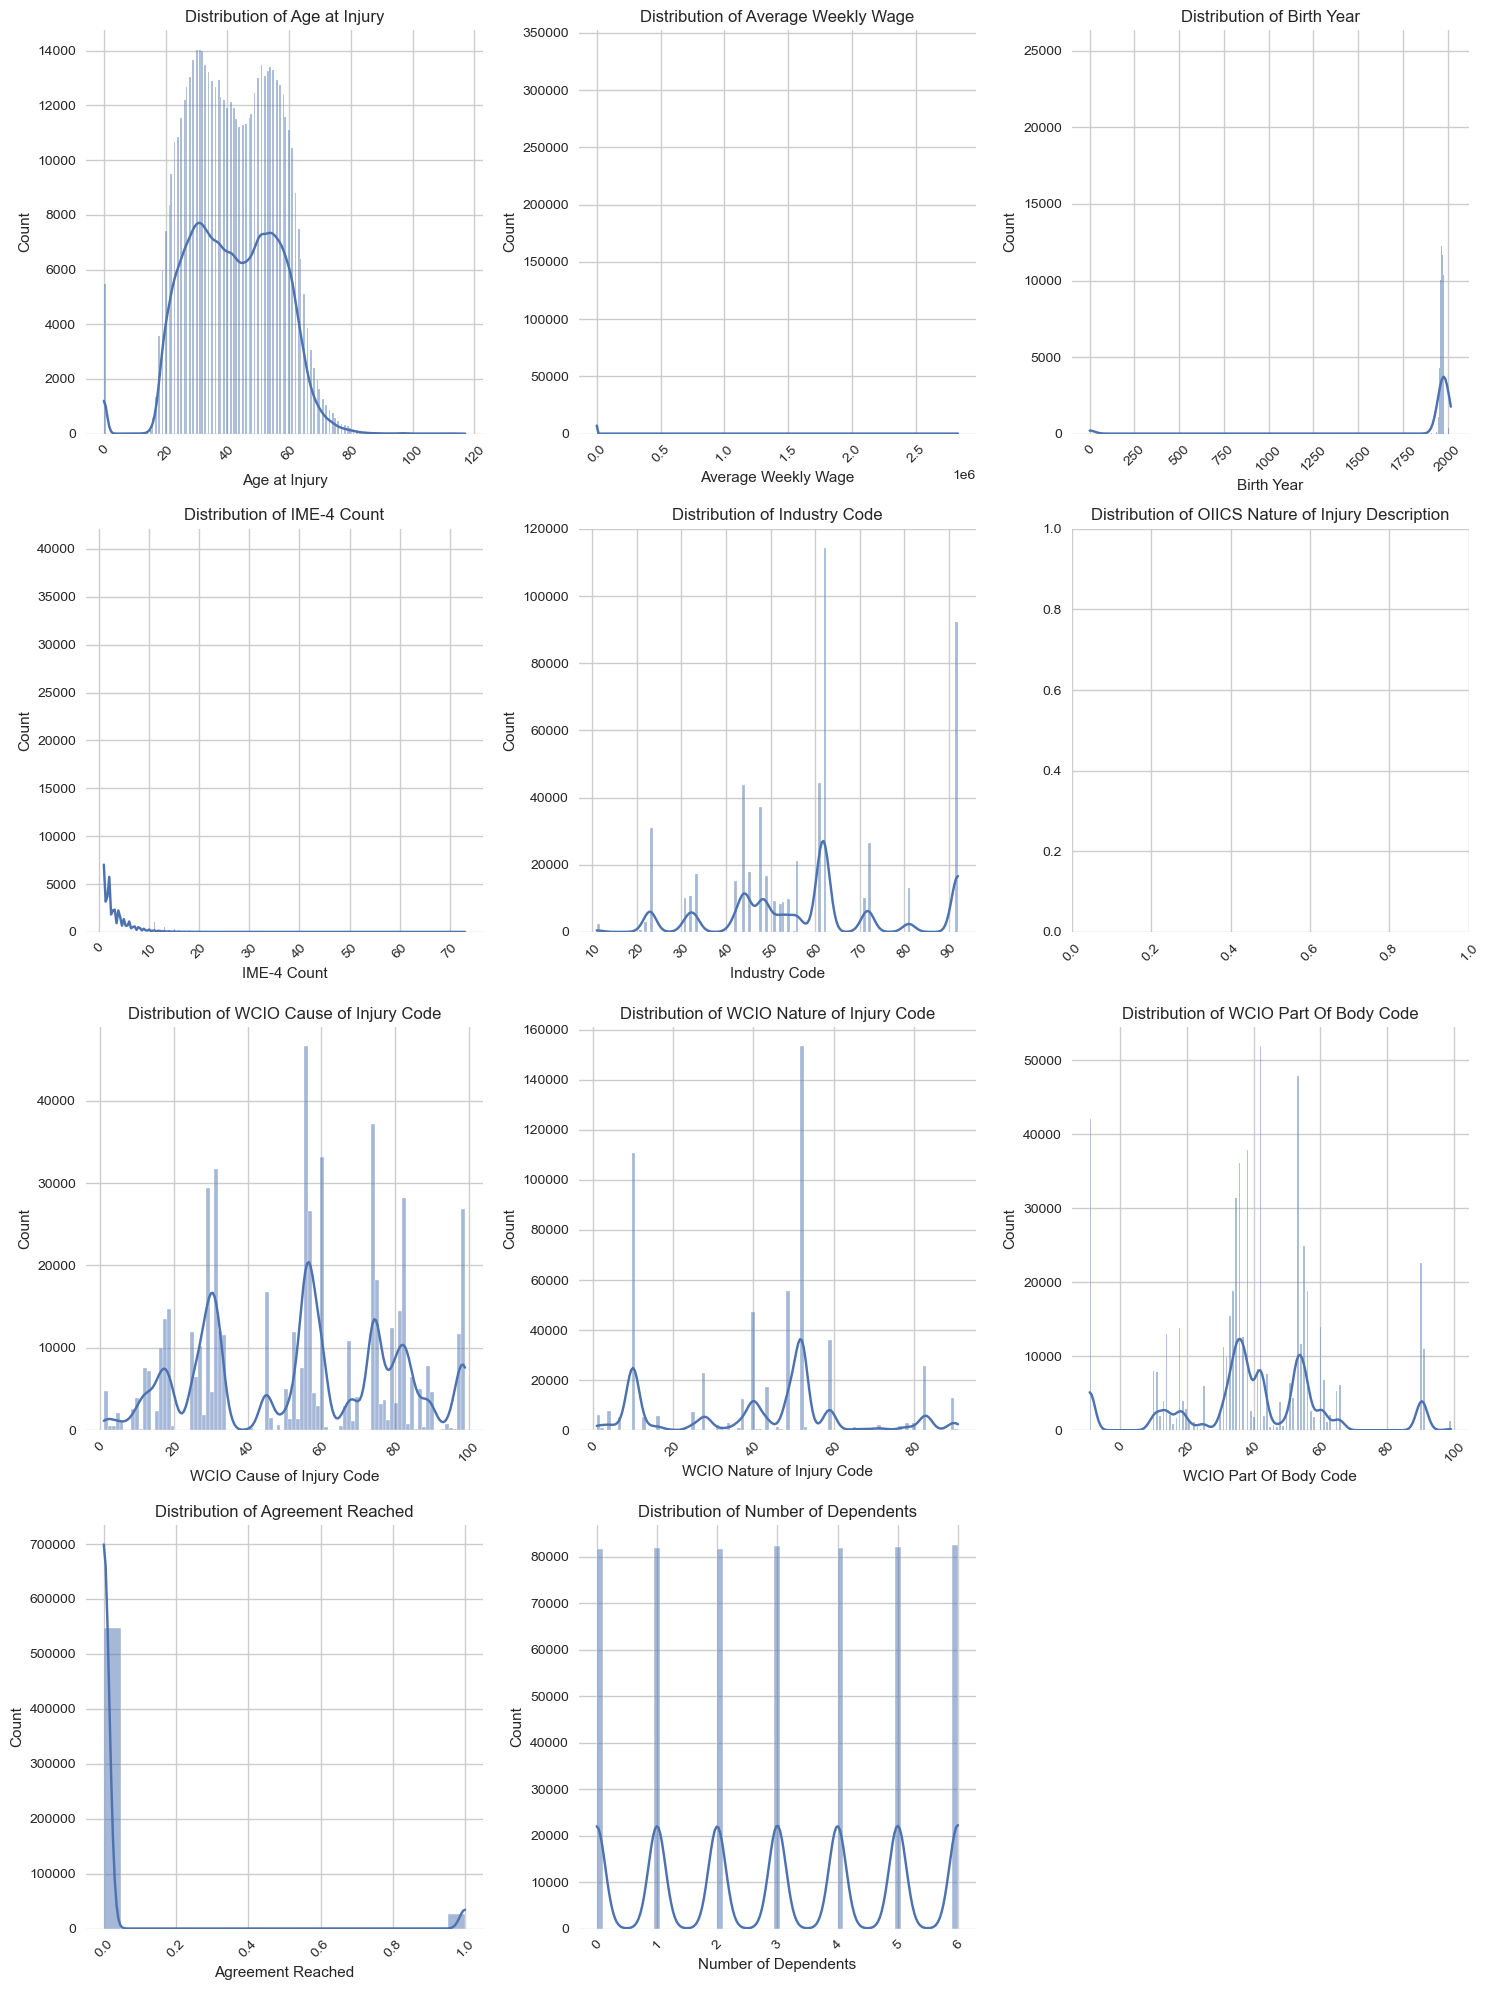

In [19]:
plt.figure(figsize=(15, 5 * ((len(numeric_cols) + 2) // 3)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i)
    sns.histplot(data=train_df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

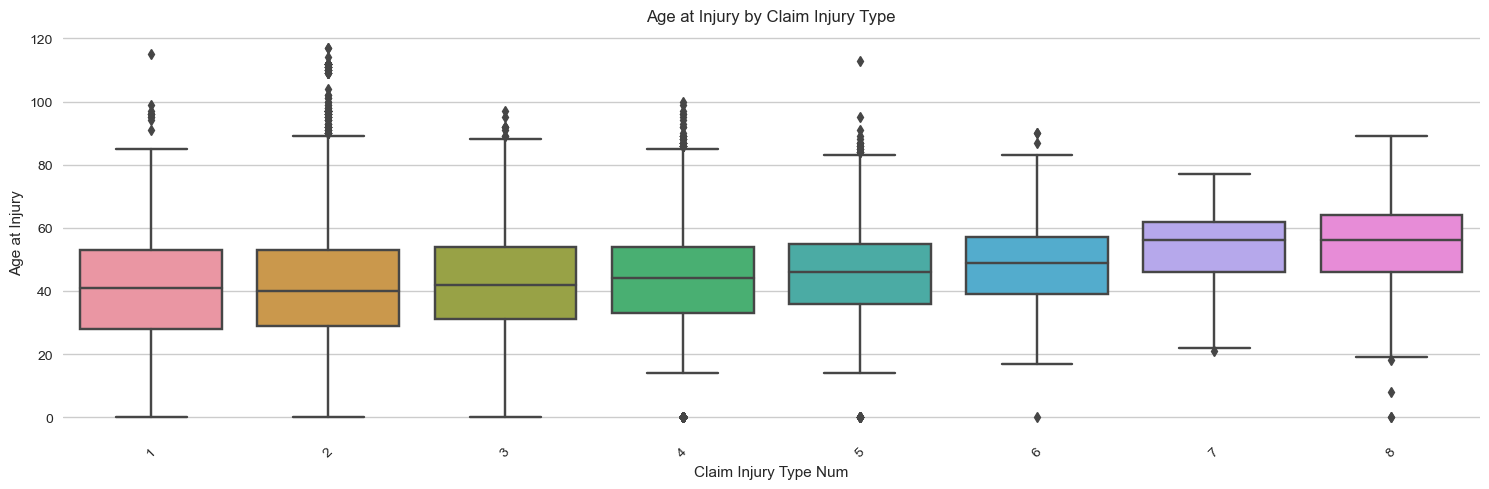

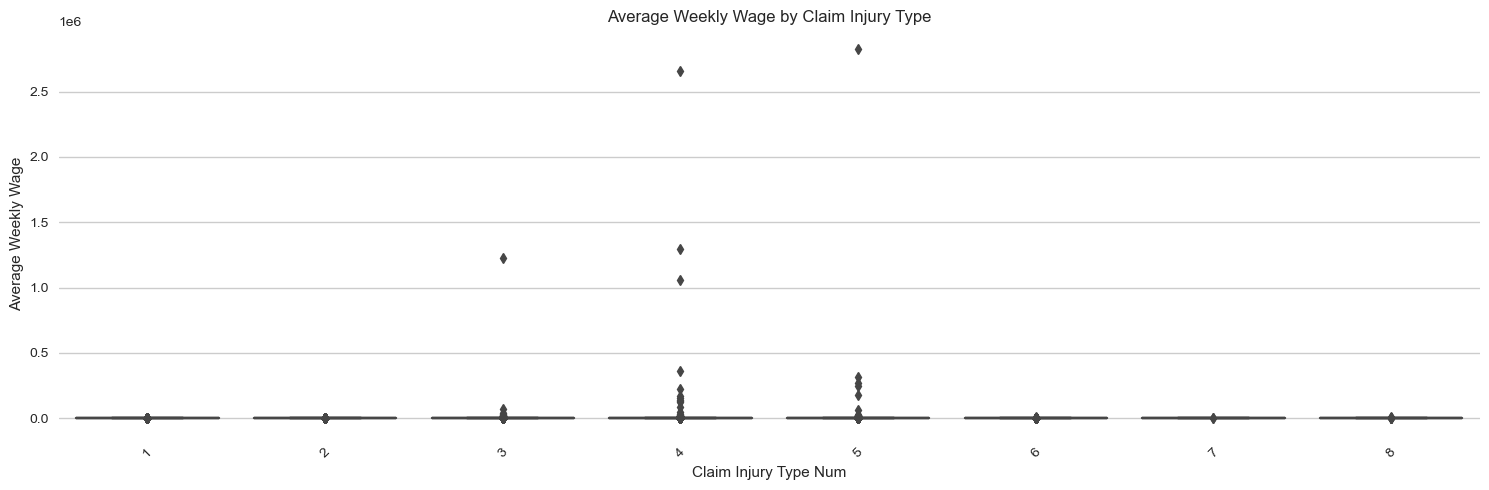

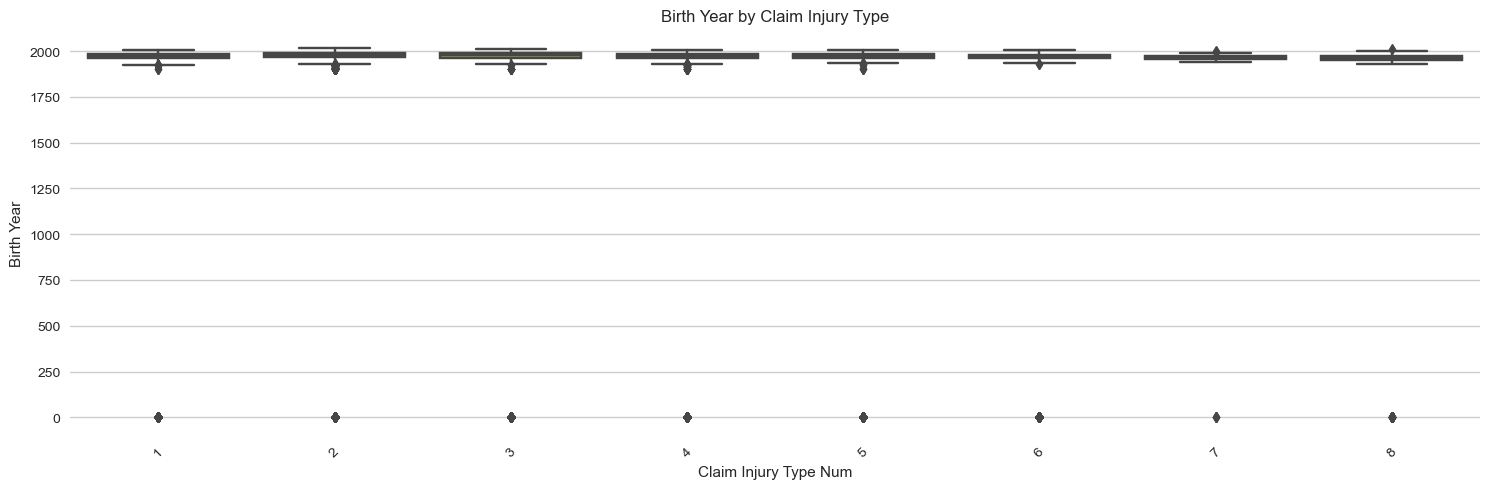

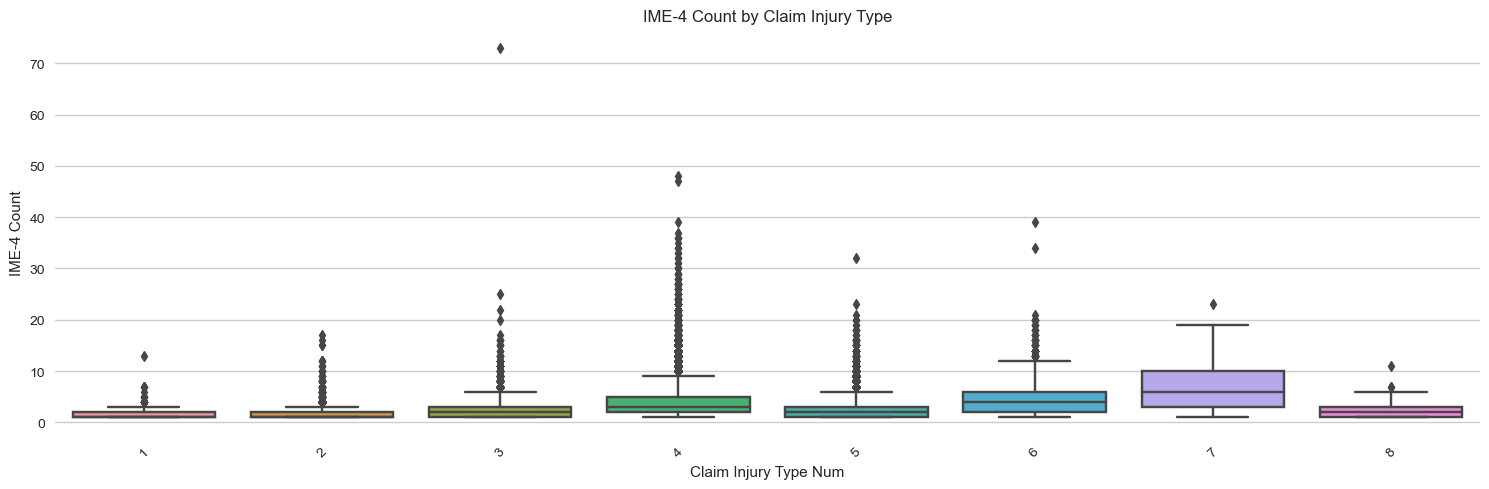

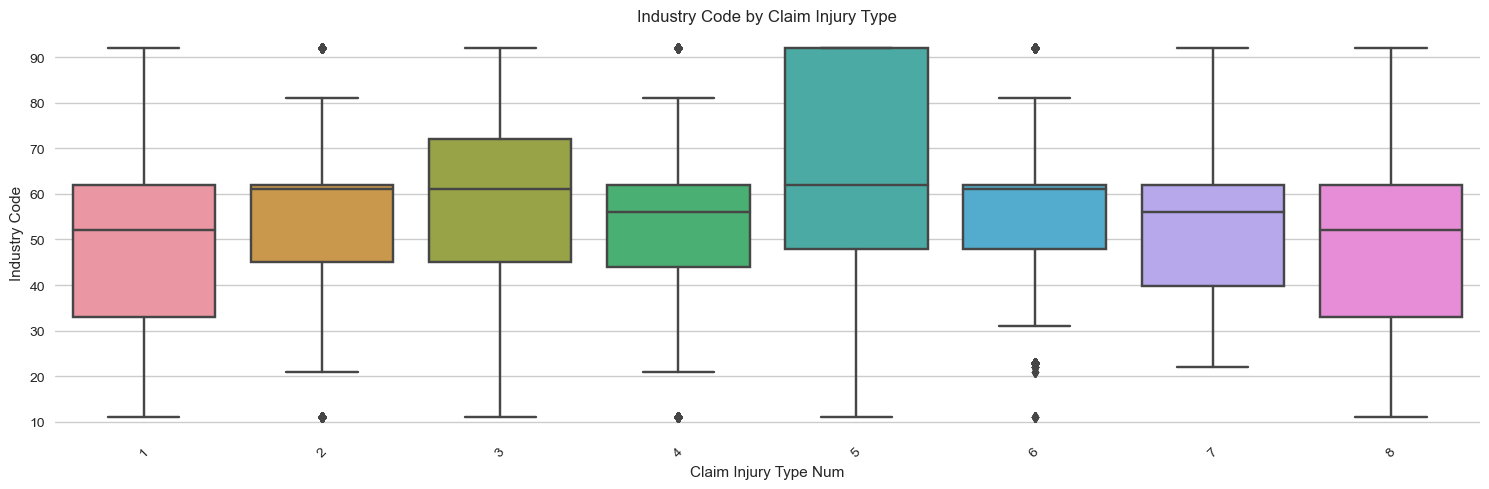

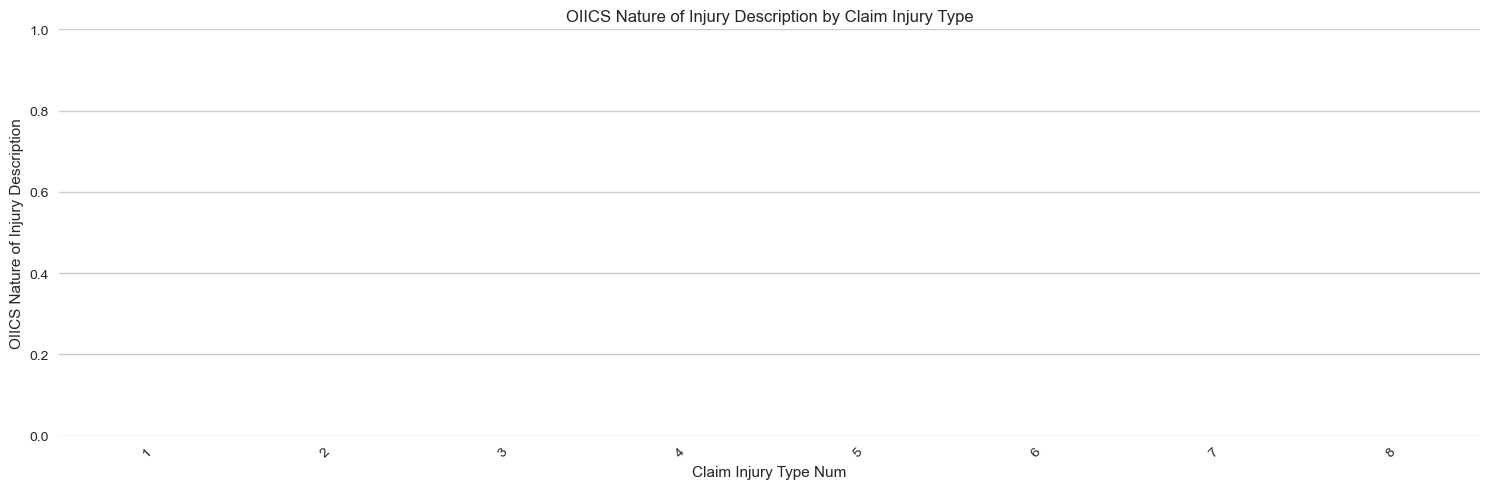

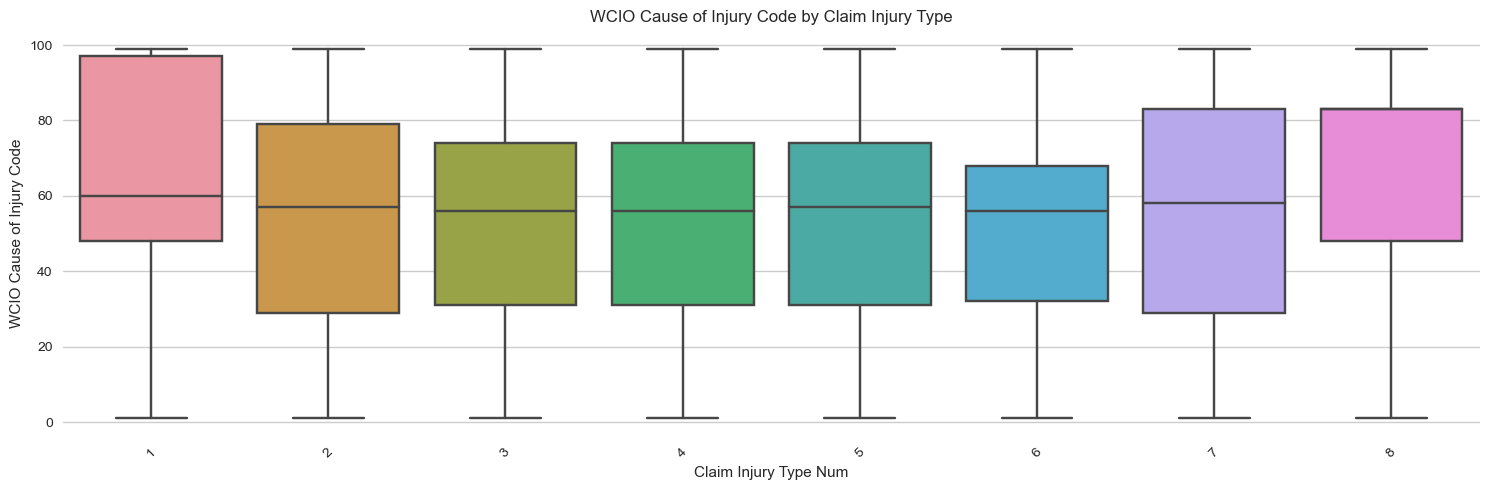

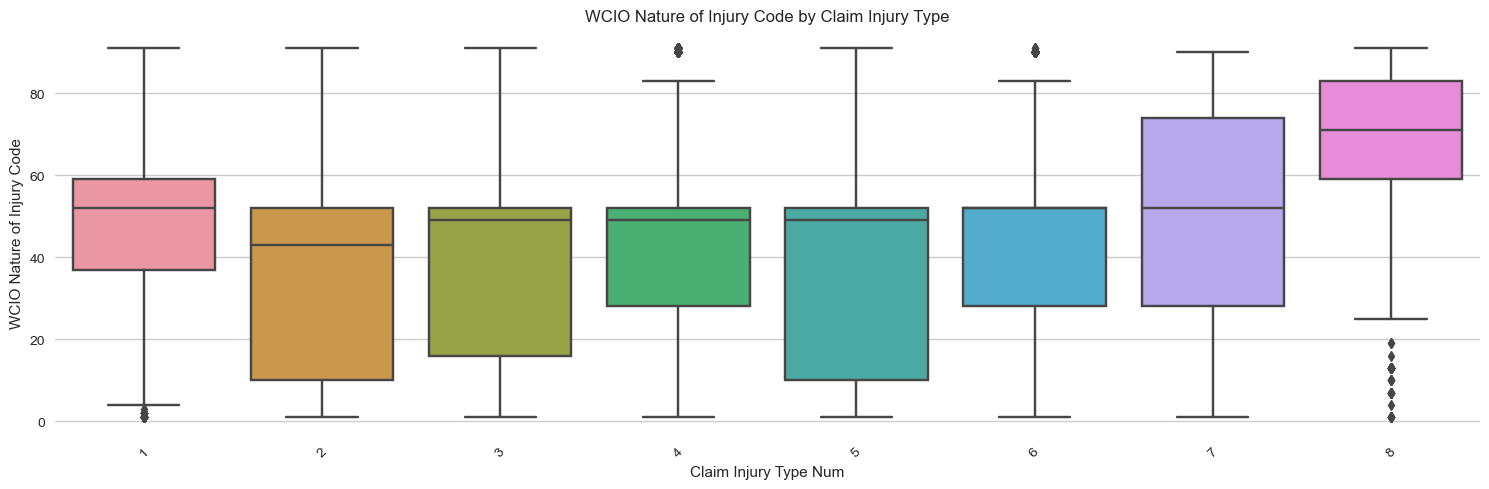

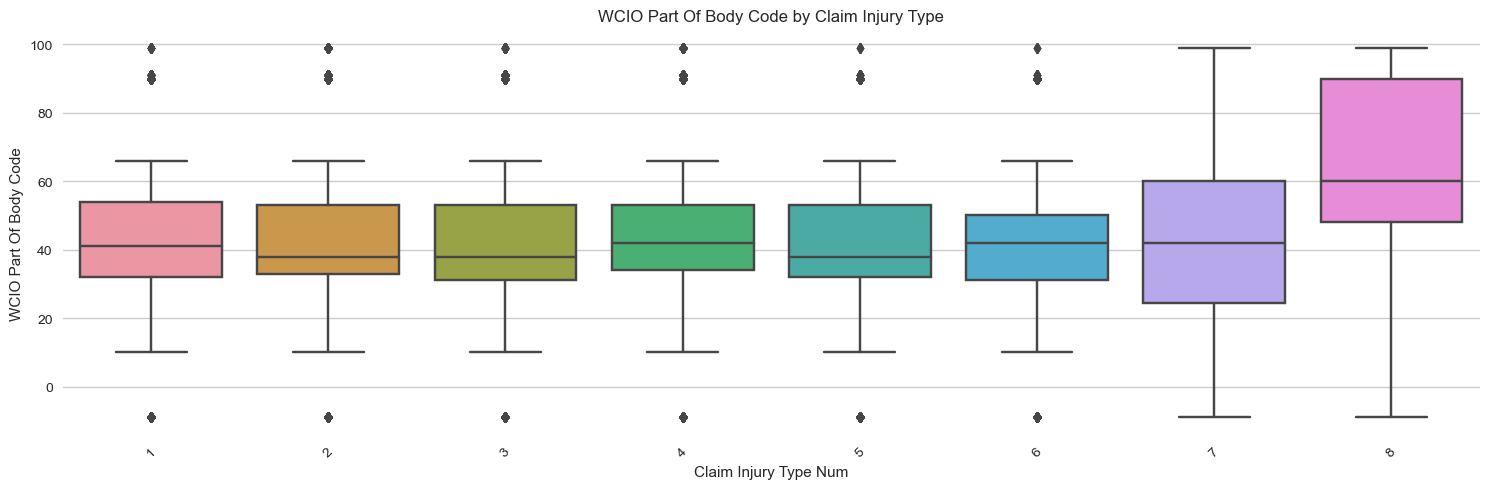

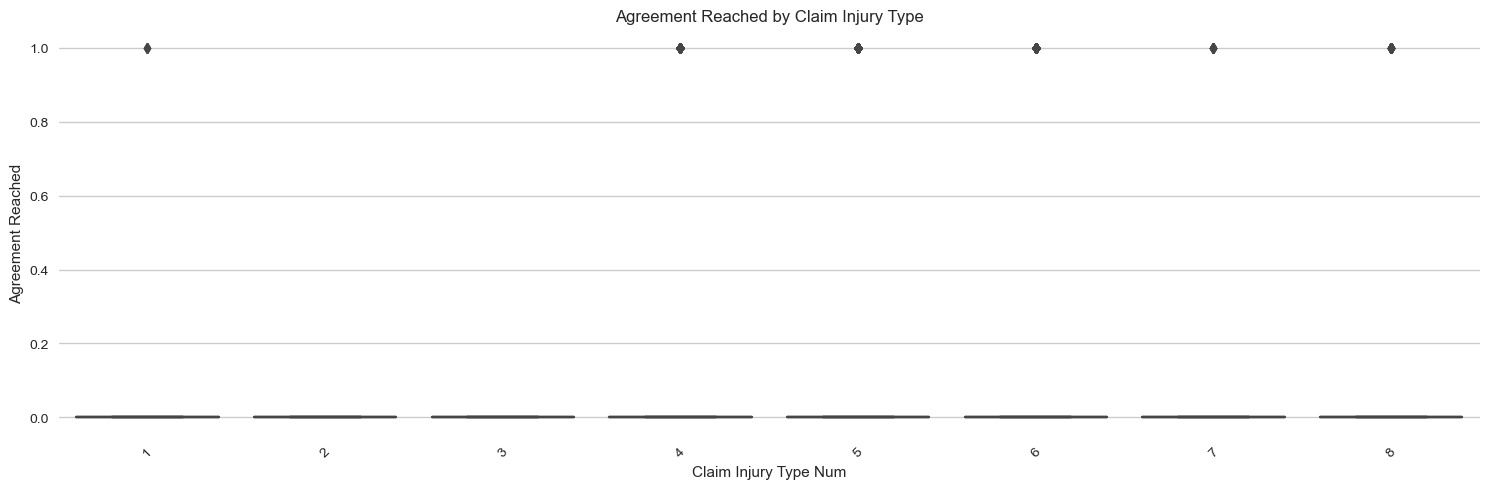

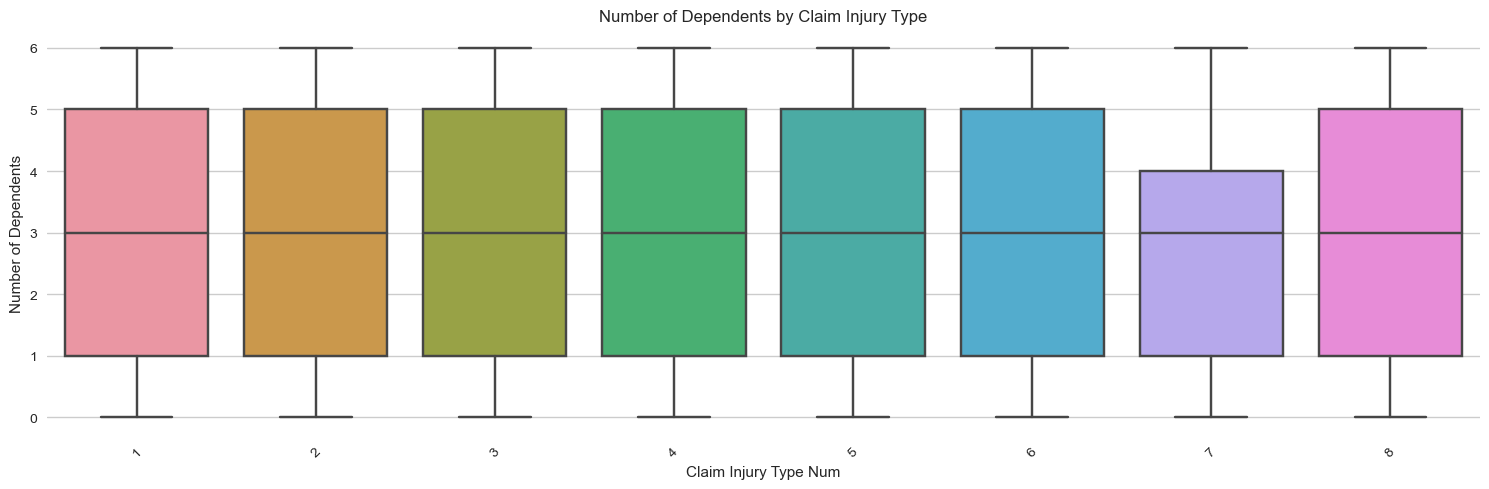

In [20]:
for col in numeric_cols:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=train_df, x='Claim Injury Type Num', y=col)
    plt.title(f'{col} by Claim Injury Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

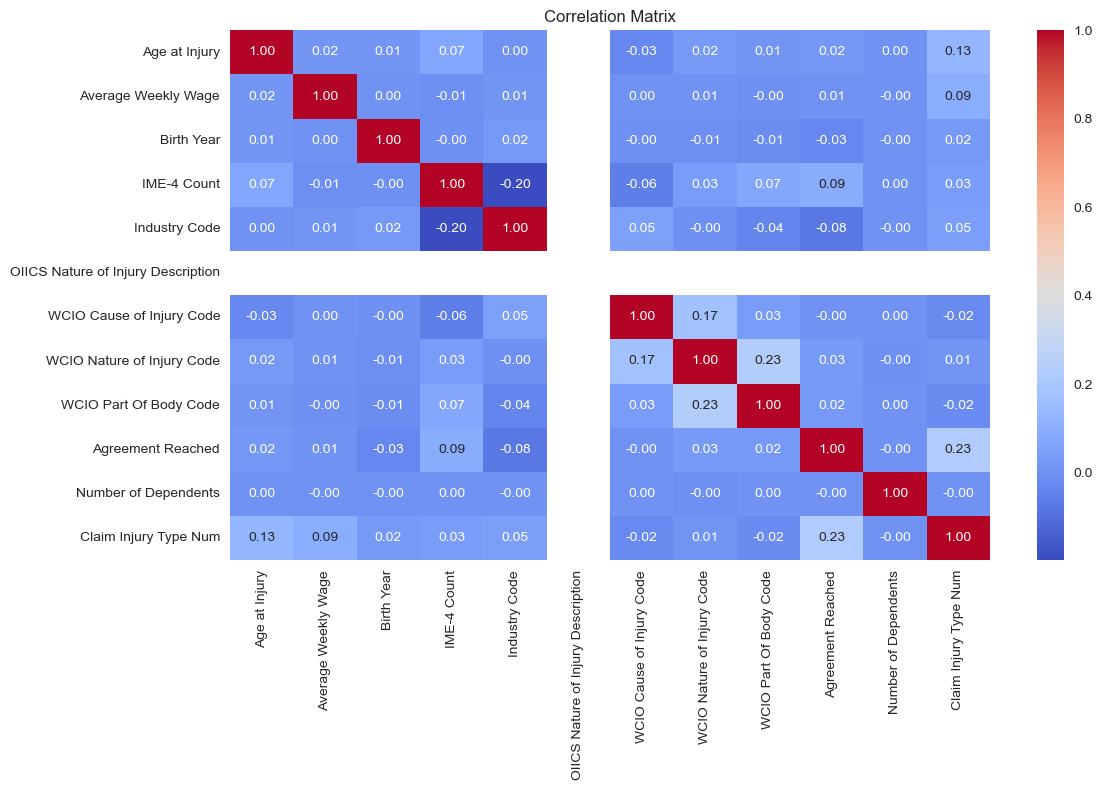

In [21]:
correlation_matrix = train_df[numeric_cols + ['Claim Injury Type Num']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [22]:
target_correlations = correlation_matrix['Claim Injury Type Num'].drop('Claim Injury Type Num')
print("\nFeature Correlations with Target (sorted by absolute value):")
print(target_correlations.abs().sort_values(ascending=False))


Feature Correlations with Target (sorted by absolute value):
Agreement Reached                     0.225043
Age at Injury                         0.126114
Average Weekly Wage                   0.091868
Industry Code                         0.045021
IME-4 Count                           0.031527
WCIO Cause of Injury Code             0.023351
Birth Year                            0.022443
WCIO Part Of Body Code                0.019712
WCIO Nature of Injury Code            0.007839
Number of Dependents                  0.000464
OIICS Nature of Injury Description         NaN
Name: Claim Injury Type Num, dtype: float64


In [23]:
categorical_cols = train_df.select_dtypes(include=['object']).columns


Analyzing Accident Date:
Number of unique values: 5539

Top 10 most frequent values:
2020-03-01    1245
2020-12-18    1001
2022-02-07     977
2022-01-05     883
2021-02-18     851
2021-02-08     850
2020-02-06     846
2022-01-31     835
2022-01-20     818
2021-09-15     814
Name: Accident Date, dtype: int64


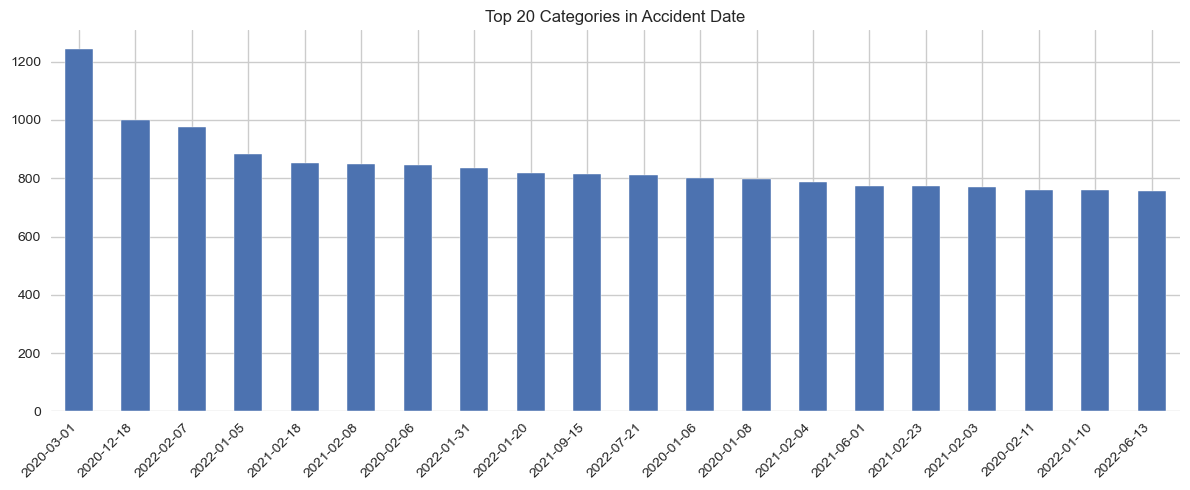

<Figure size 1200x600 with 0 Axes>

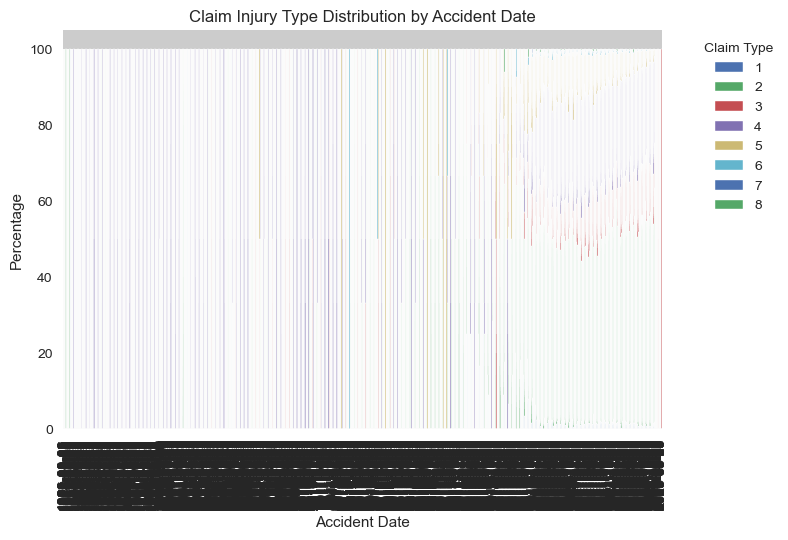


Analyzing Alternative Dispute Resolution:
Number of unique values: 3

Top 10 most frequent values:
N    571412
Y      2609
U         5
Name: Alternative Dispute Resolution, dtype: int64


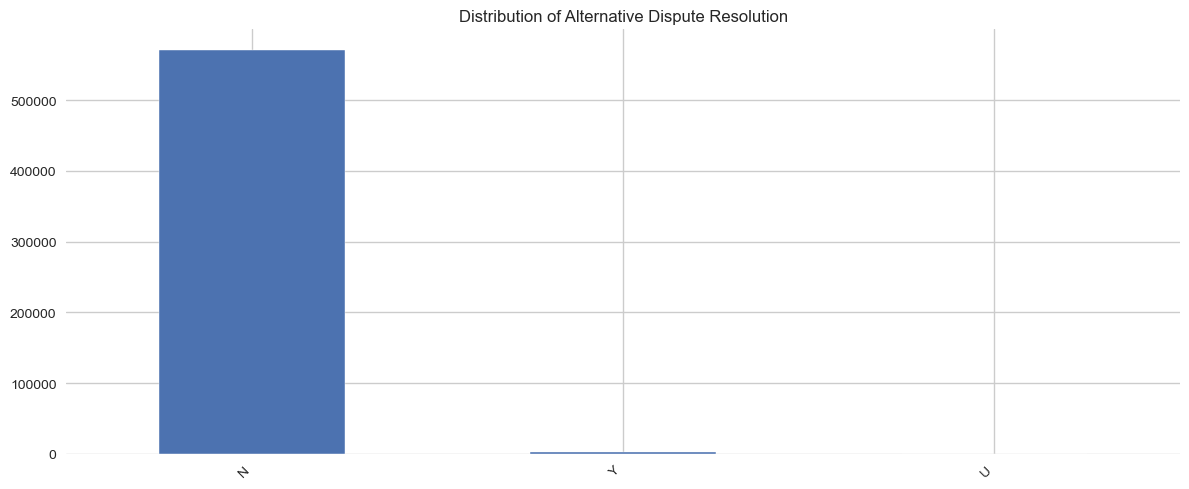

<Figure size 1200x600 with 0 Axes>

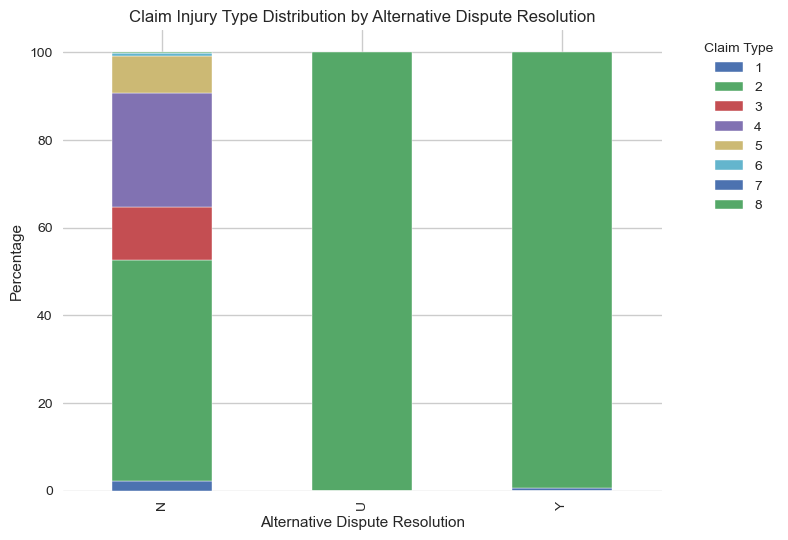


Analyzing Assembly Date:
Number of unique values: 897

Top 10 most frequent values:
2020-03-06    1413
2021-05-11    1370
2022-04-01    1233
2022-02-04    1194
2022-08-15    1151
2021-08-03    1107
2022-02-07    1105
2021-06-25    1087
2020-02-28    1072
2022-08-01    1063
Name: Assembly Date, dtype: int64


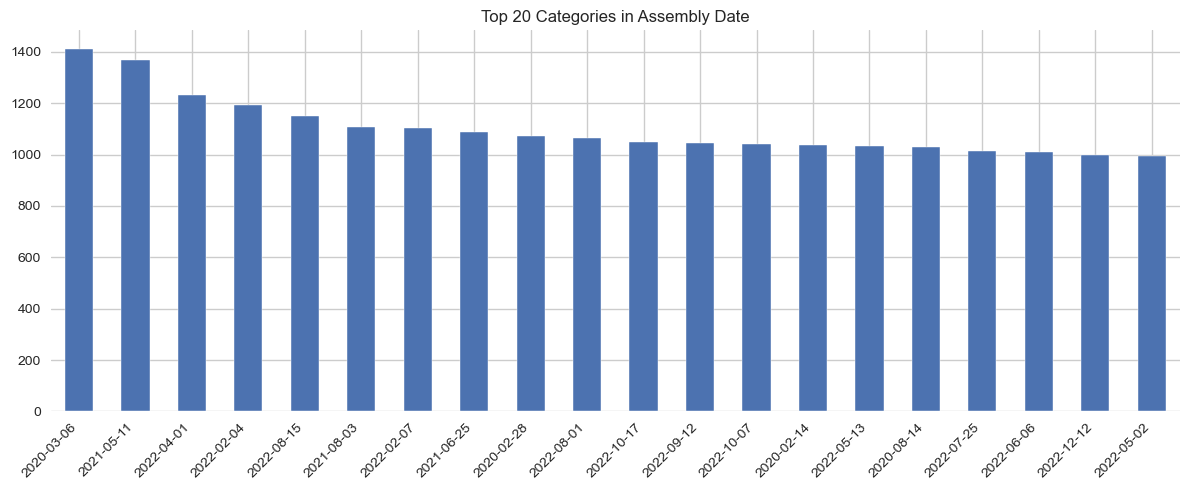

<Figure size 1200x600 with 0 Axes>

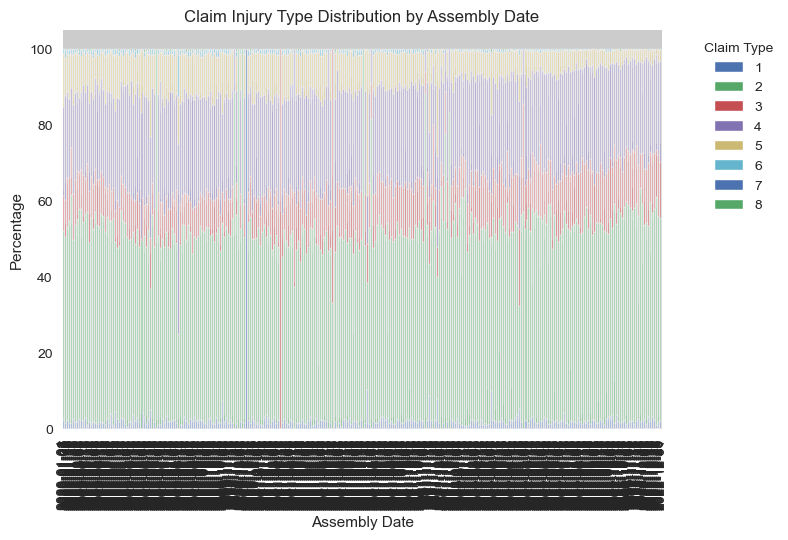


Analyzing Attorney/Representative:
Number of unique values: 2

Top 10 most frequent values:
N    392291
Y    181735
Name: Attorney/Representative, dtype: int64


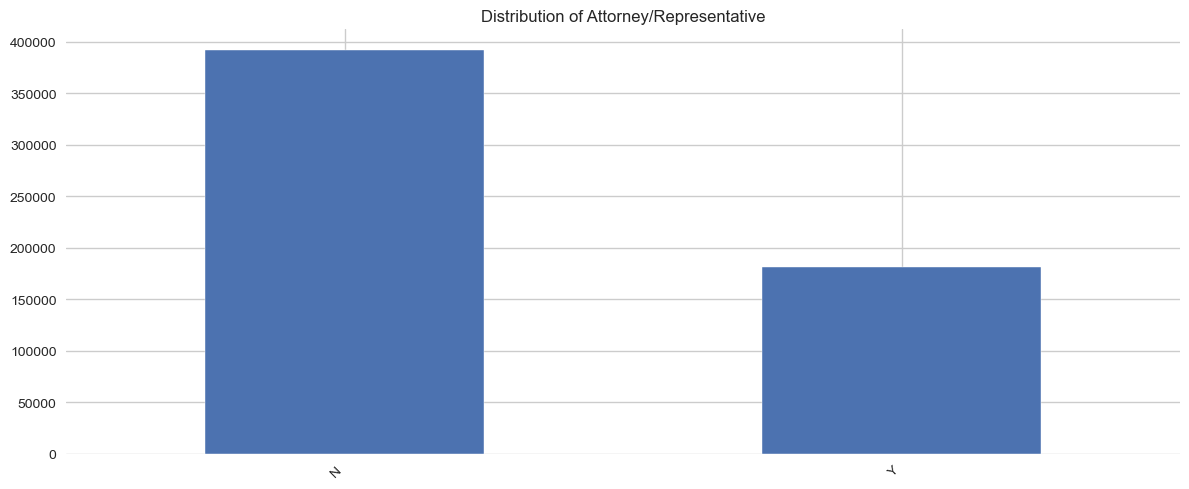

<Figure size 1200x600 with 0 Axes>

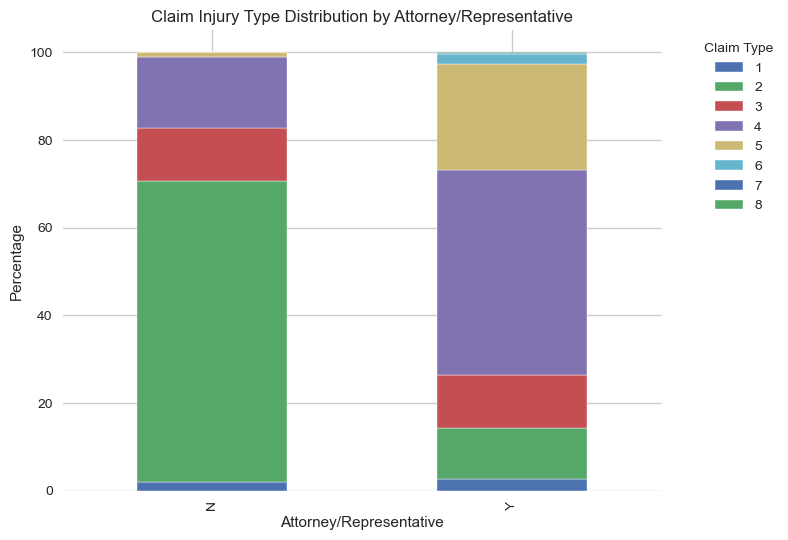


Analyzing C-2 Date:
Number of unique values: 2475

Top 10 most frequent values:
2021-05-11    1847
2020-03-05    1348
2021-05-27    1271
2022-08-15    1134
2021-06-22    1081
2021-06-24    1077
2022-03-30    1018
2021-02-11    1012
2022-07-06    1005
2022-02-11     974
Name: C-2 Date, dtype: int64


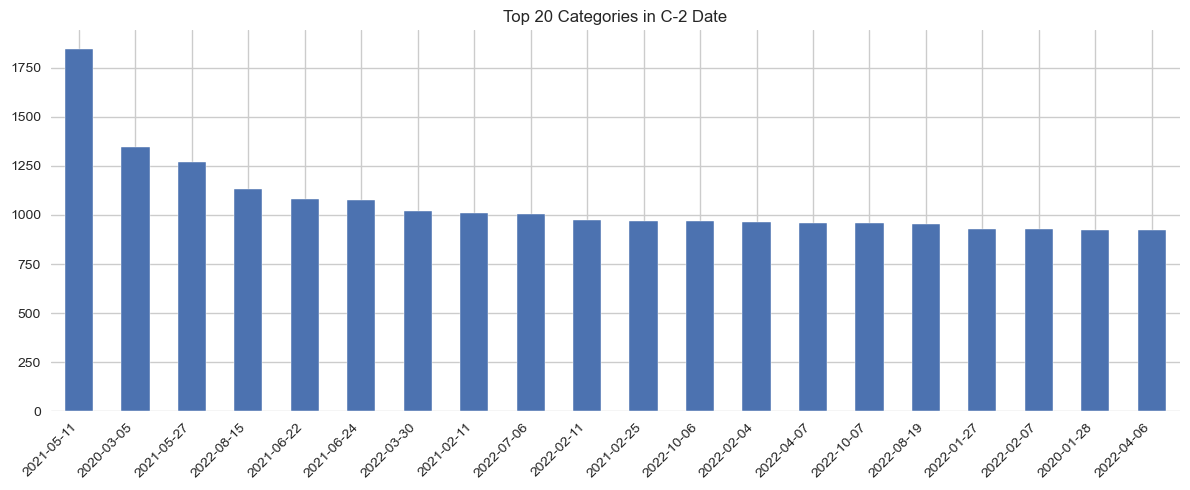

<Figure size 1200x600 with 0 Axes>

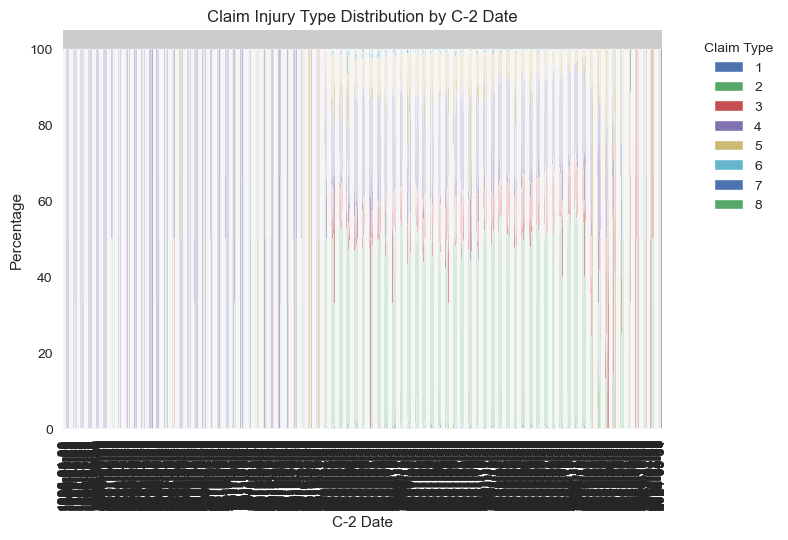


Analyzing C-3 Date:
Number of unique values: 1648

Top 10 most frequent values:
2021-04-21    350
2020-02-10    347
2020-10-26    347
2020-09-23    345
2021-06-28    340
2022-03-07    337
2021-06-21    337
2021-03-02    335
2021-03-04    333
2020-08-10    329
Name: C-3 Date, dtype: int64


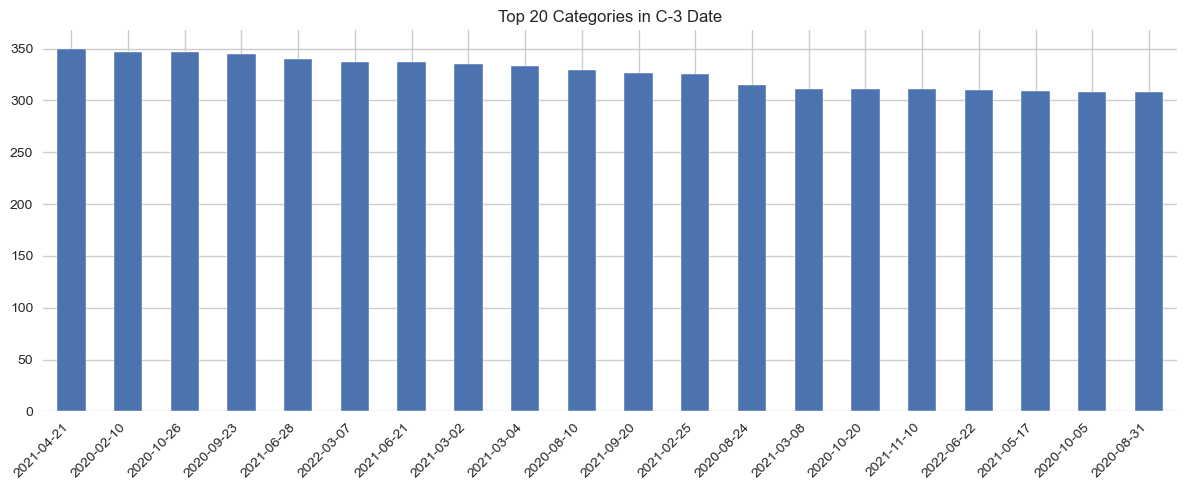

<Figure size 1200x600 with 0 Axes>

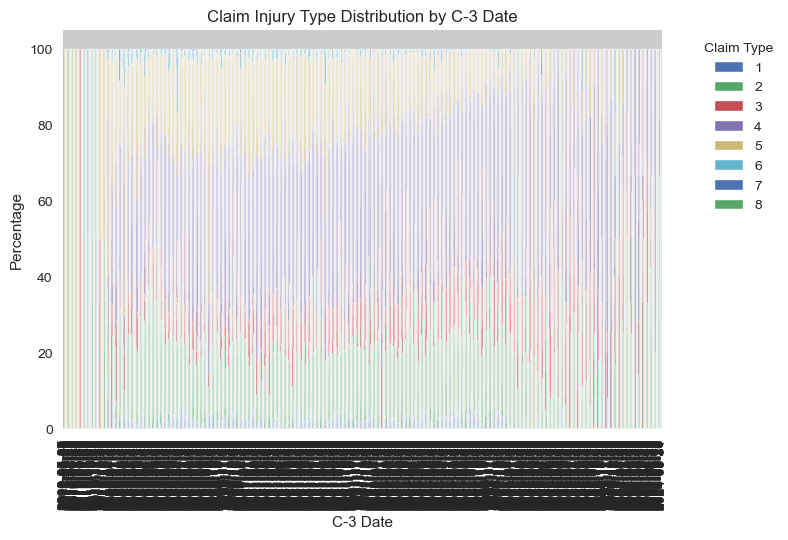


Analyzing Carrier Name:
Number of unique values: 2046

Top 10 most frequent values:
STATE INSURANCE FUND             111144
POLICE, FIRE, SANITATION          21602
AMERICAN ZURICH INSURANCE CO      17540
CHARTER OAK FIRE INS CO           17176
INDEMNITY INS. OF N AMERICA       14366
SAFETY NATIONAL CASUALTY CORP     13941
NEW HAMPSHIRE INSURANCE CO        12736
LM INSURANCE CORP                 12274
A I U INSURANCE COMPANY           11038
INDEMNITY INSURANCE CO OF          9126
Name: Carrier Name, dtype: int64


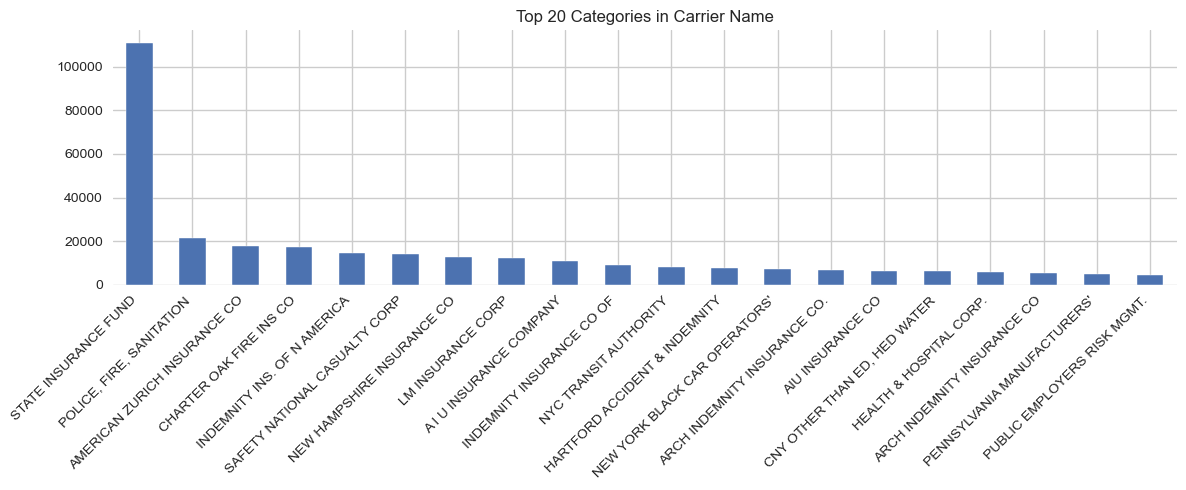

<Figure size 1200x600 with 0 Axes>

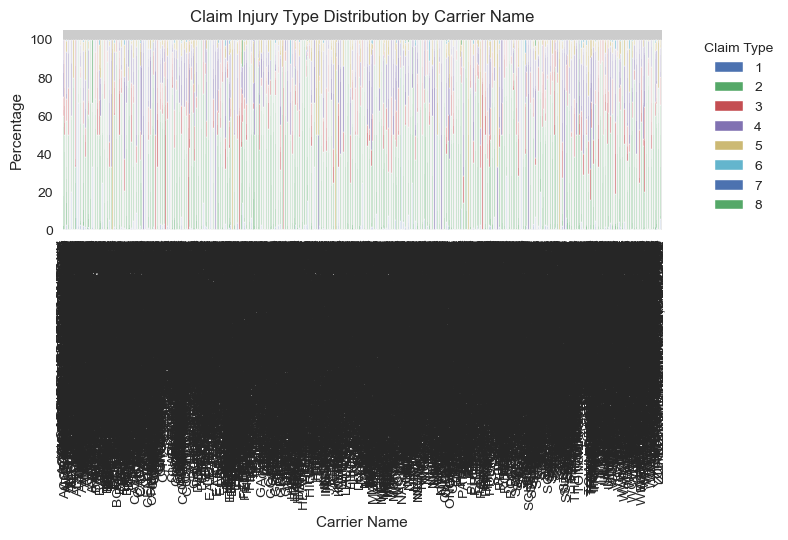


Analyzing Carrier Type:
Number of unique values: 8

Top 10 most frequent values:
1A. PRIVATE                                    285368
3A. SELF PUBLIC                                121920
2A. SIF                                        111144
4A. SELF PRIVATE                                52788
UNKNOWN                                          1774
5D. SPECIAL FUND - UNKNOWN                       1023
5C. SPECIAL FUND - POI CARRIER WCB MENANDS          5
5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)         4
Name: Carrier Type, dtype: int64


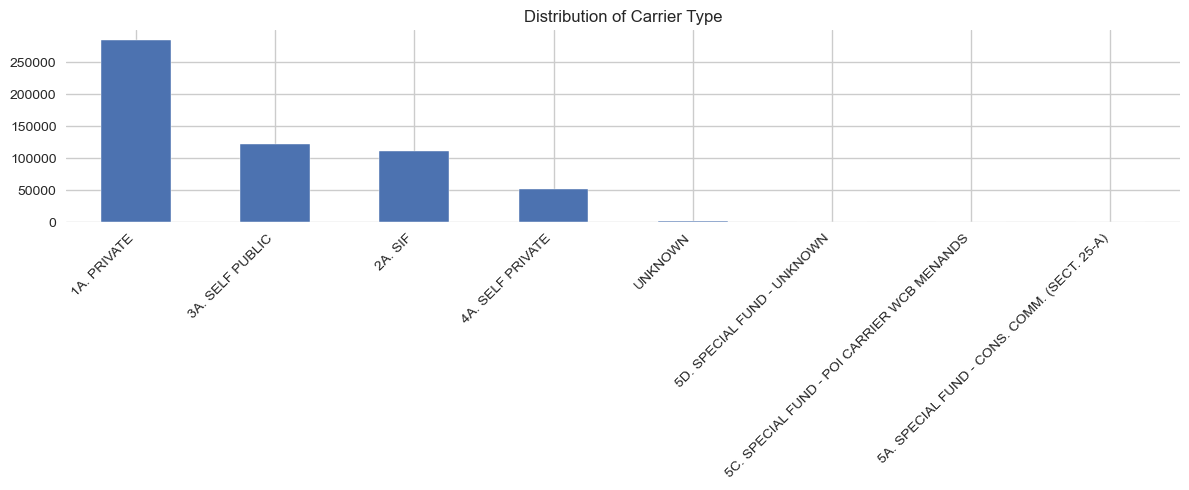

<Figure size 1200x600 with 0 Axes>

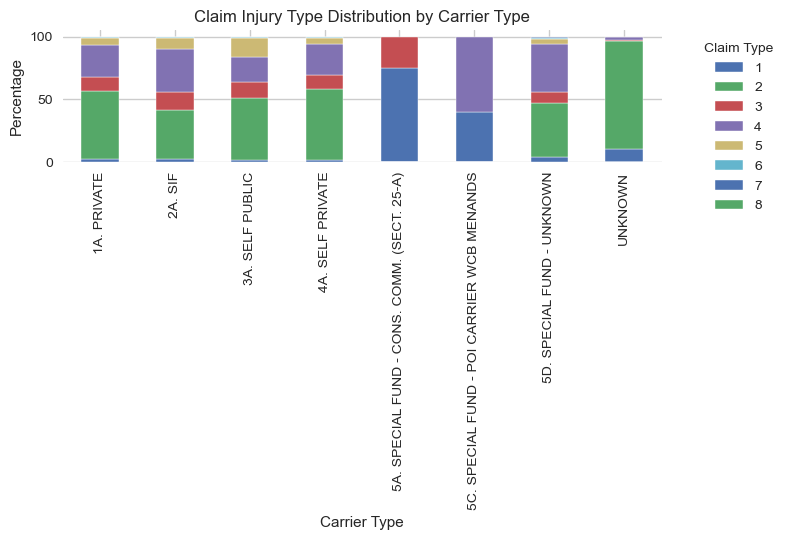


Analyzing Claim Injury Type:
Number of unique values: 8

Top 10 most frequent values:
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: Claim Injury Type, dtype: int64


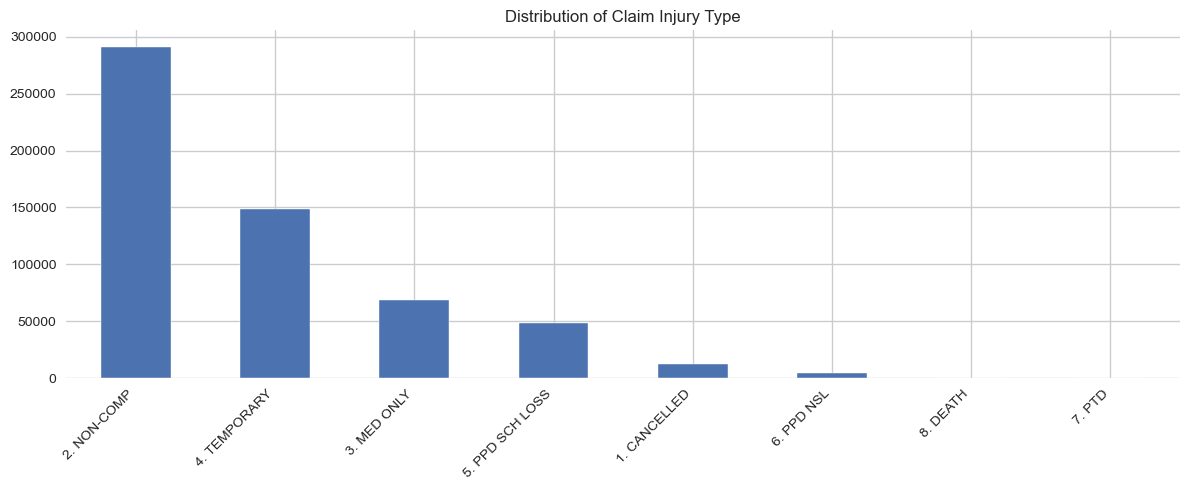

<Figure size 1200x600 with 0 Axes>

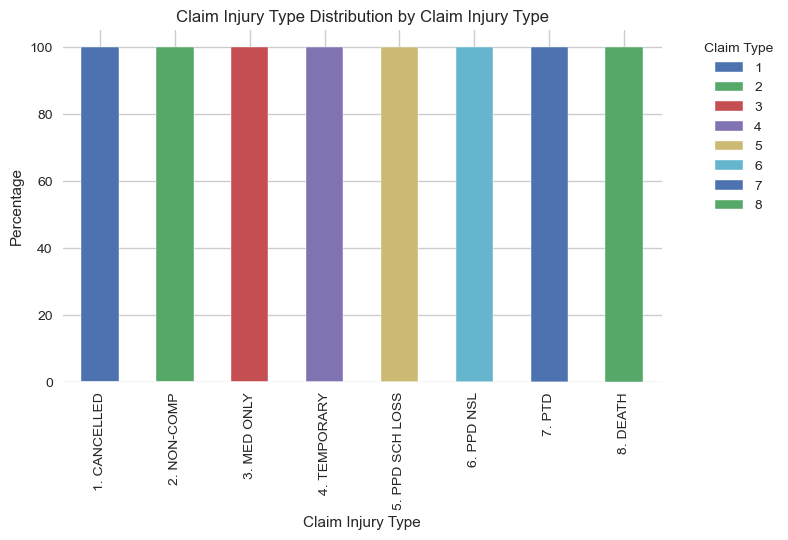


Analyzing County of Injury:
Number of unique values: 63

Top 10 most frequent values:
SUFFOLK        60430
QUEENS         58333
KINGS          53207
NASSAU         43580
BRONX          39618
ERIE           30874
NEW YORK       30014
WESTCHESTER    25754
MONROE         24071
ORANGE         17450
Name: County of Injury, dtype: int64


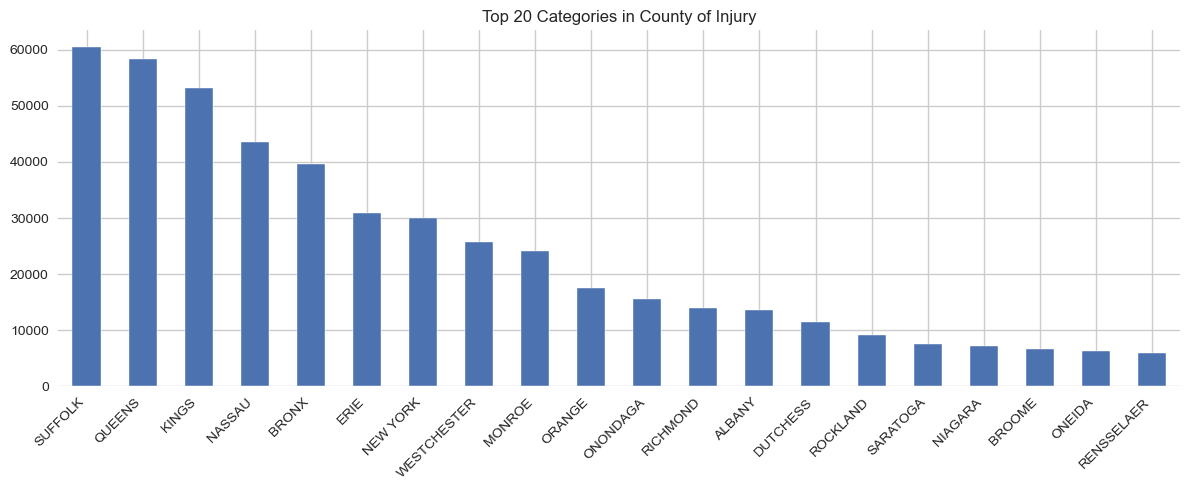

<Figure size 1200x600 with 0 Axes>

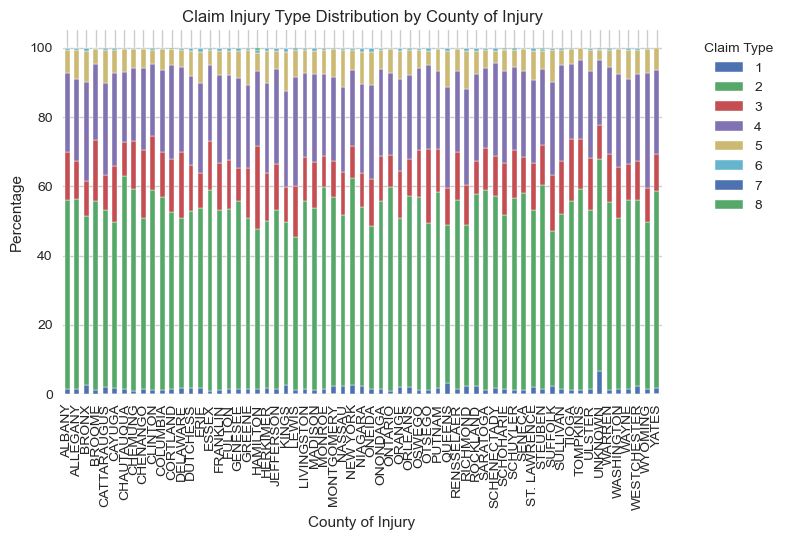


Analyzing COVID-19 Indicator:
Number of unique values: 2

Top 10 most frequent values:
N    546505
Y     27521
Name: COVID-19 Indicator, dtype: int64


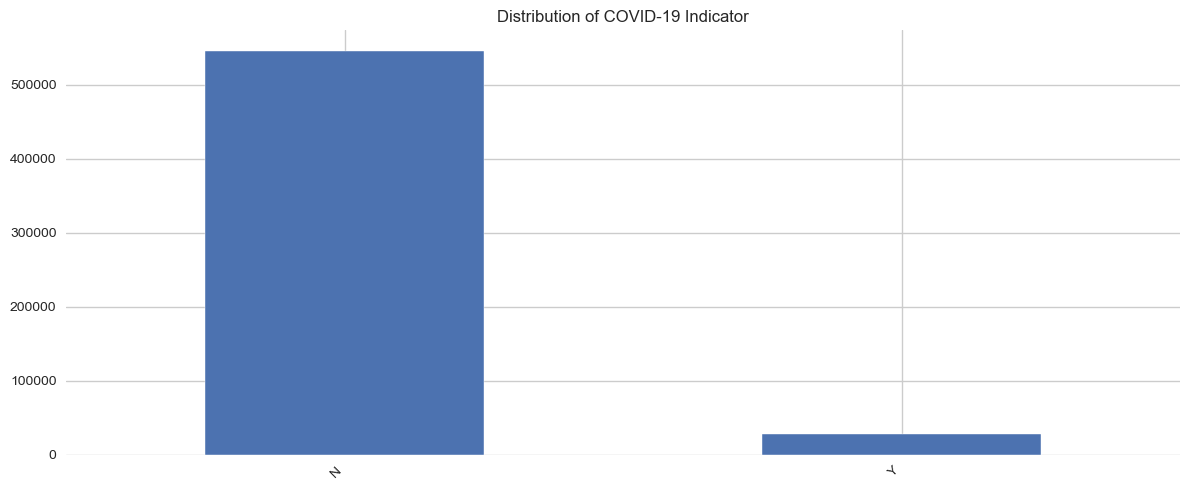

<Figure size 1200x600 with 0 Axes>

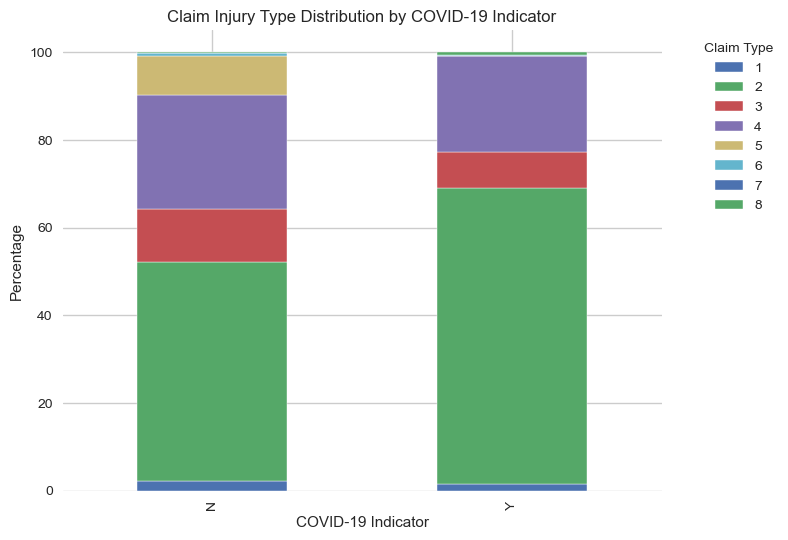


Analyzing District Name:
Number of unique values: 8

Top 10 most frequent values:
NYC           270779
ALBANY         86171
HAUPPAUGE      60536
BUFFALO        45605
SYRACUSE       44646
ROCHESTER      40449
BINGHAMTON     21864
STATEWIDE       3976
Name: District Name, dtype: int64


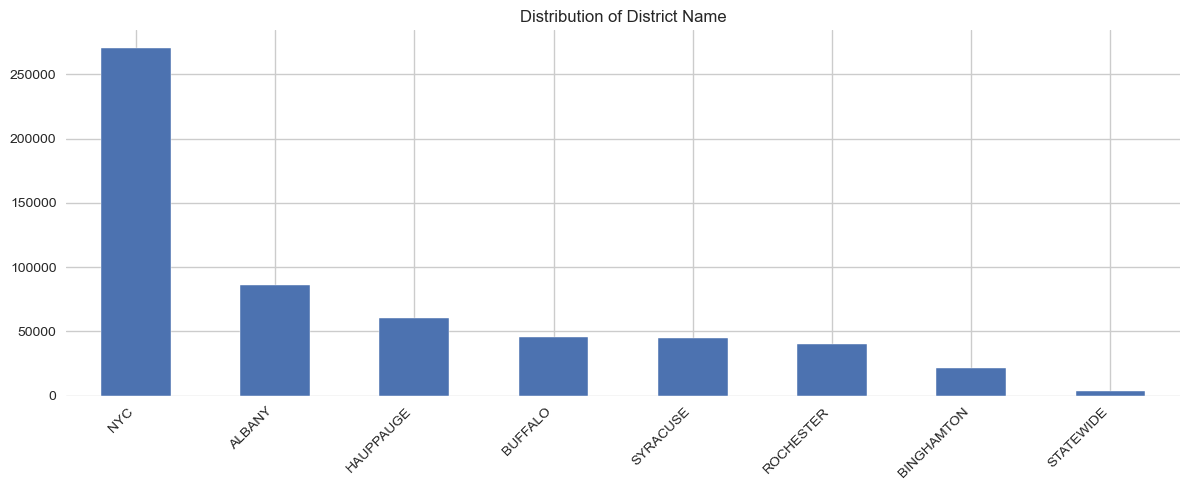

<Figure size 1200x600 with 0 Axes>

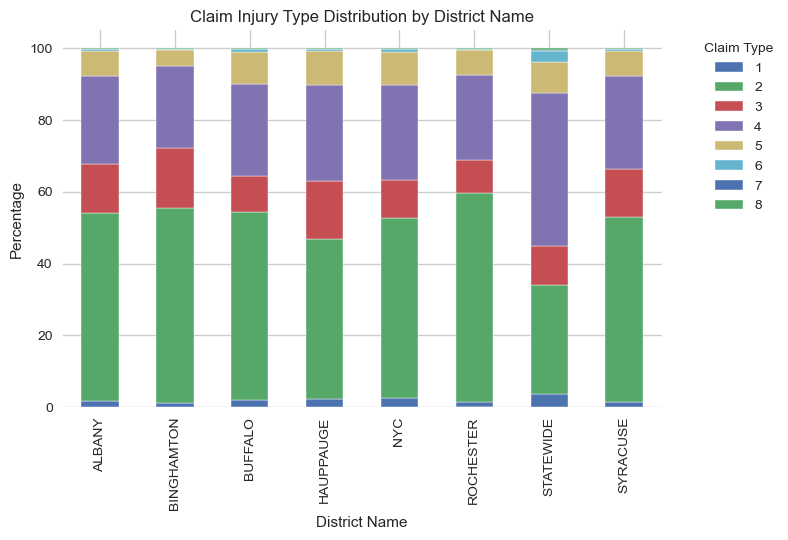


Analyzing First Hearing Date:
Number of unique values: 1094

Top 10 most frequent values:
2022-04-15    440
2022-01-20    418
2022-02-15    402
2020-12-21    382
2021-05-25    381
2022-08-09    344
2021-09-01    330
2023-02-09    318
2021-10-18    313
2021-06-07    312
Name: First Hearing Date, dtype: int64


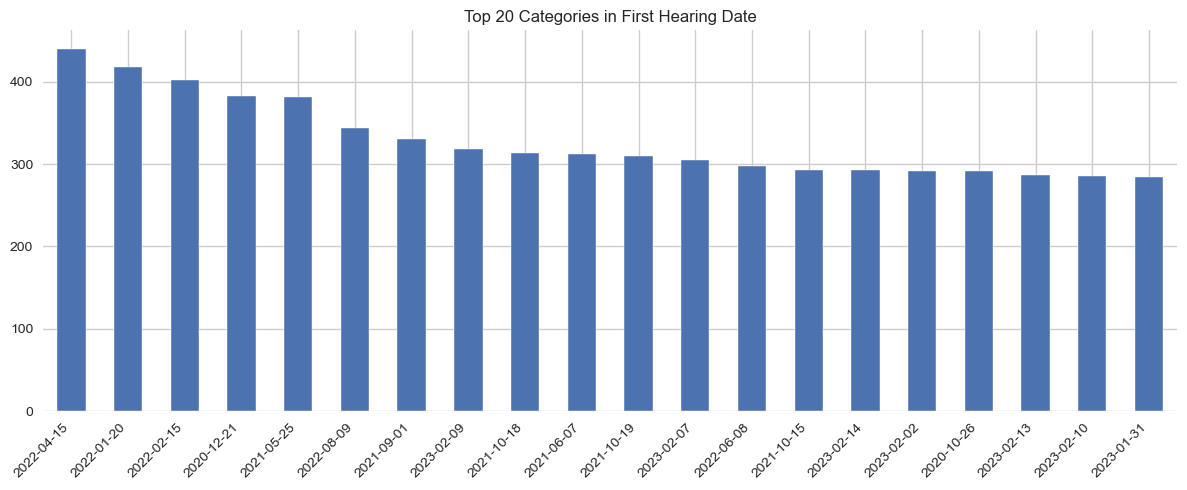

<Figure size 1200x600 with 0 Axes>

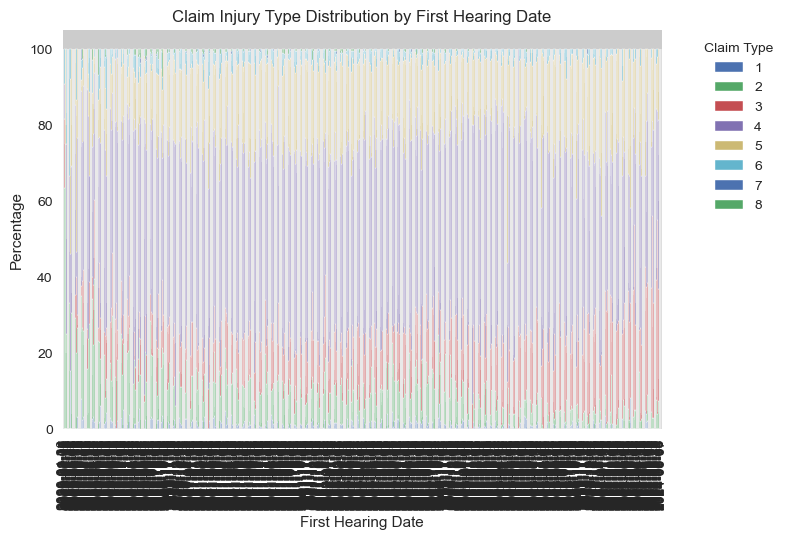


Analyzing Gender:
Number of unique values: 4

Top 10 most frequent values:
M    335218
F    234051
U      4711
X        46
Name: Gender, dtype: int64


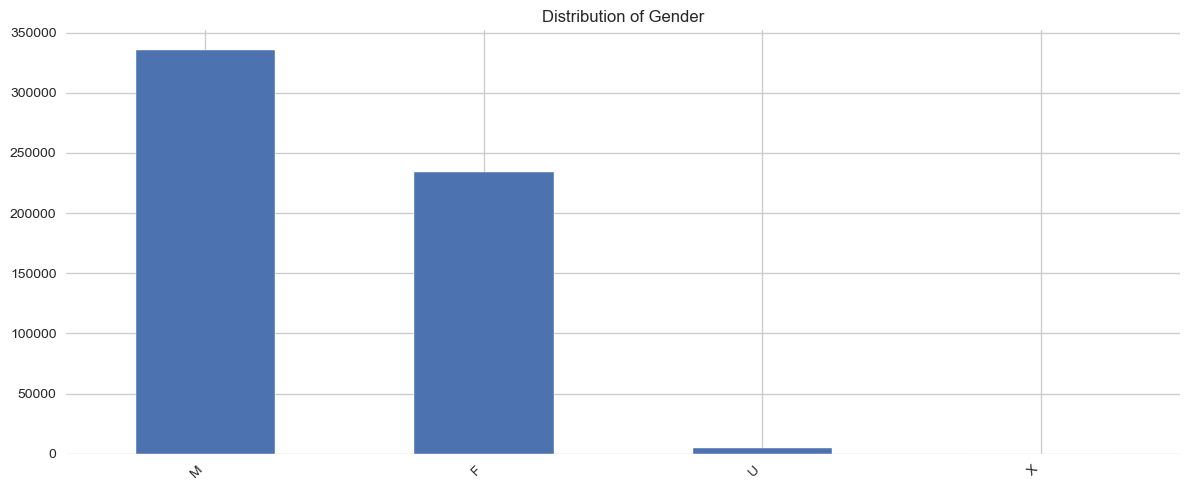

<Figure size 1200x600 with 0 Axes>

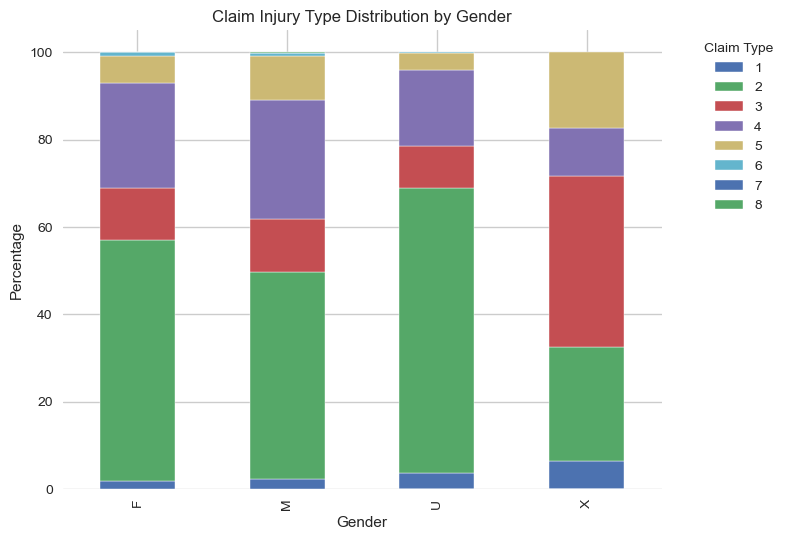


Analyzing Industry Code Description:
Number of unique values: 20

Top 10 most frequent values:
HEALTH CARE AND SOCIAL ASSISTANCE                               114339
PUBLIC ADMINISTRATION                                            92240
RETAIL TRADE                                                     61638
TRANSPORTATION AND WAREHOUSING                                   54023
EDUCATIONAL SERVICES                                             44393
MANUFACTURING                                                    38150
CONSTRUCTION                                                     30903
ACCOMMODATION AND FOOD SERVICES                                  26456
ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT     21027
WHOLESALE TRADE                                                  15236
Name: Industry Code Description, dtype: int64


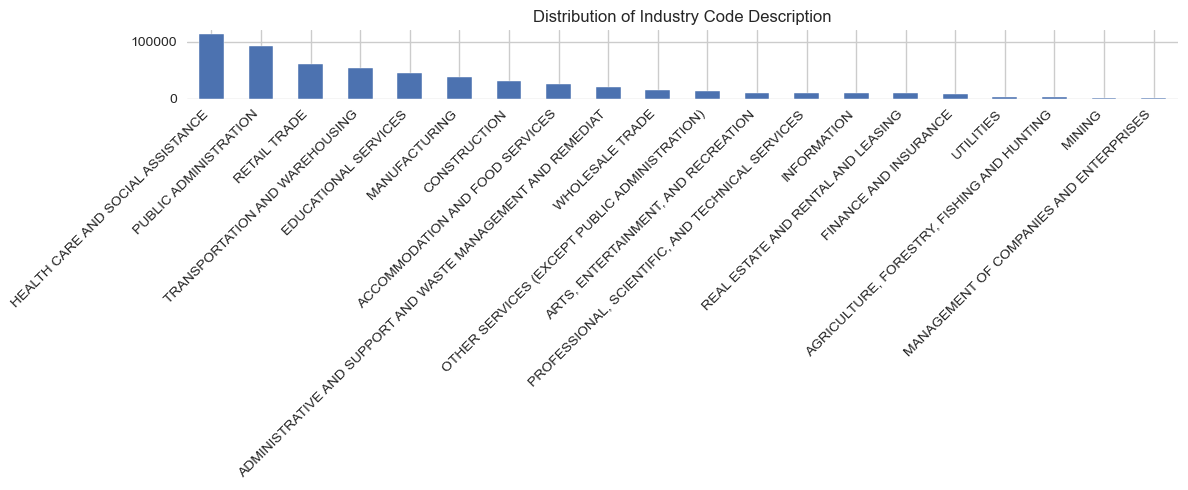

/var/folders/b9/bmsjjm2x30vcw342sbqf10xw0000gn/T/ipykernel_26735/1700799807.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

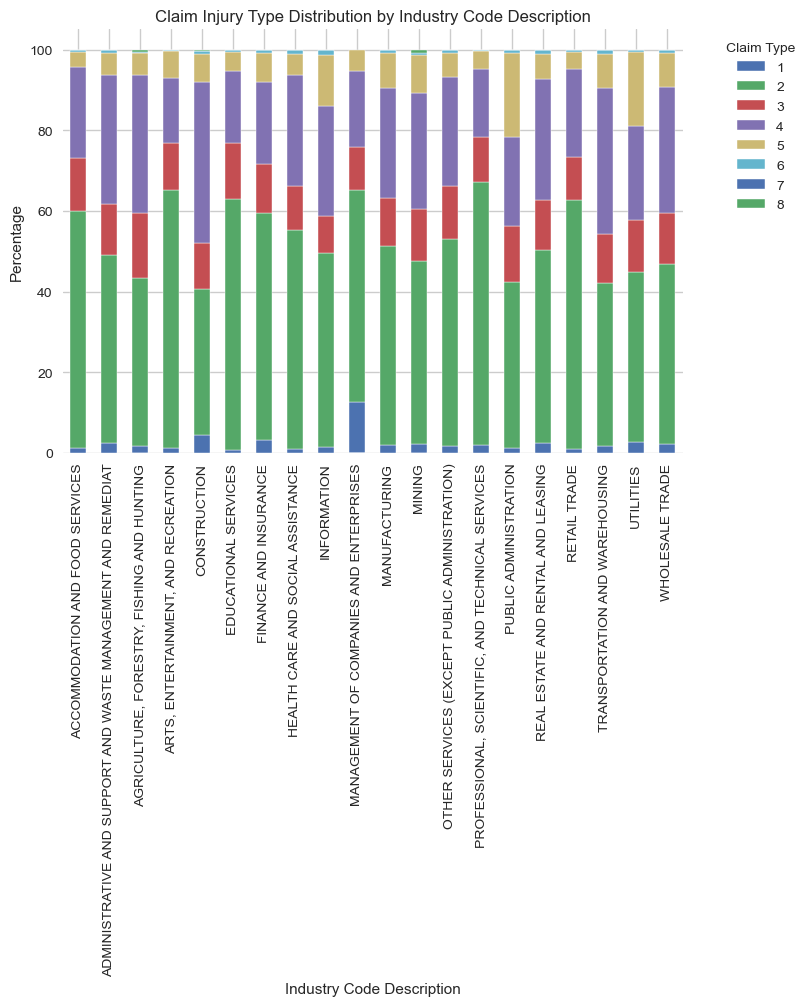


Analyzing Medical Fee Region:
Number of unique values: 5

Top 10 most frequent values:
IV     265981
I      135885
II      85033
III     53654
UK      33473
Name: Medical Fee Region, dtype: int64


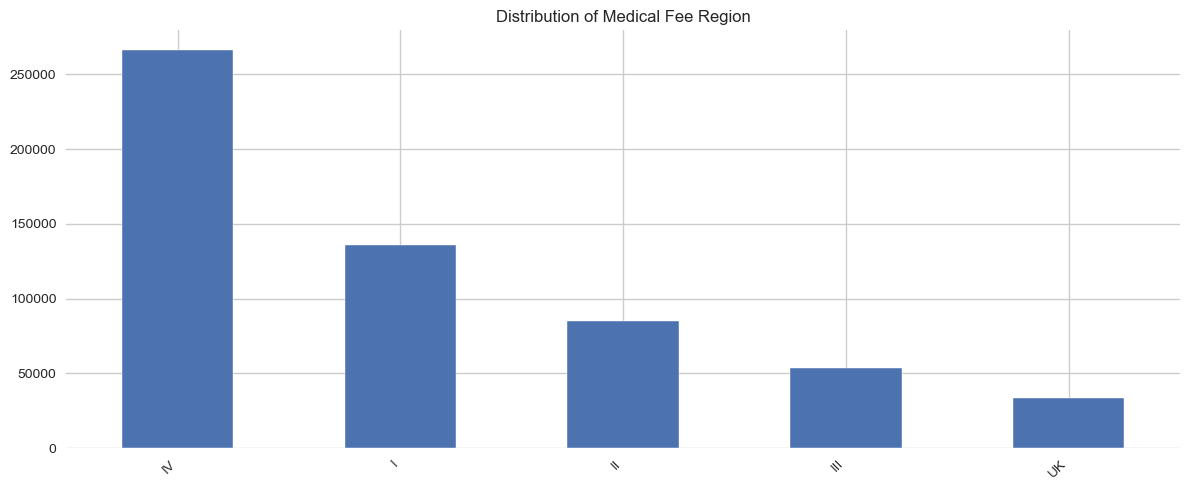

<Figure size 1200x600 with 0 Axes>

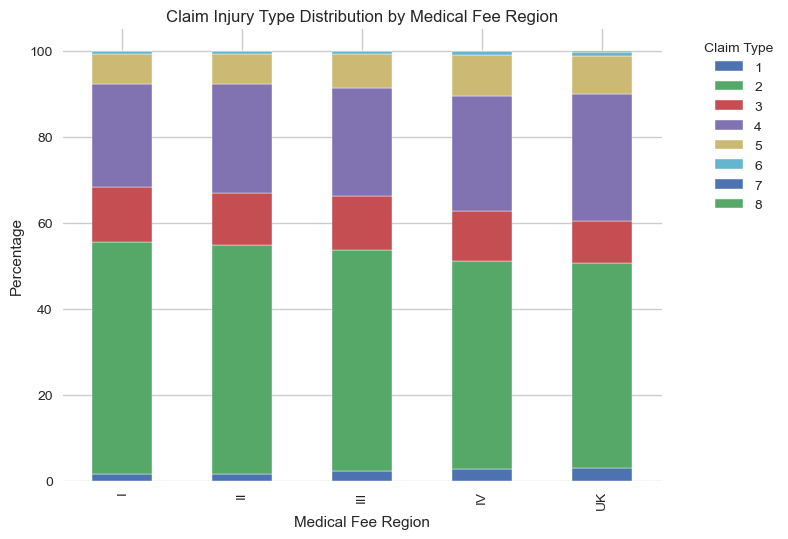


Analyzing WCIO Cause of Injury Description:
Number of unique values: 74

Top 10 most frequent values:
LIFTING                                   46610
FELLOW WORKER, PATIENT OR OTHER PERSON    37153
STRAIN OR INJURY BY, NOC                  33192
FALL, SLIP OR TRIP, NOC                   31733
ON SAME LEVEL                             29364
PUSHING OR PULLING                        26600
OBJECT BEING LIFTED OR HANDLED            25291
PANDEMIC                                  25006
OTHER - MISCELLANEOUS, NOC                22479
FALLING OR FLYING OBJECT                  18275
Name: WCIO Cause of Injury Description, dtype: int64


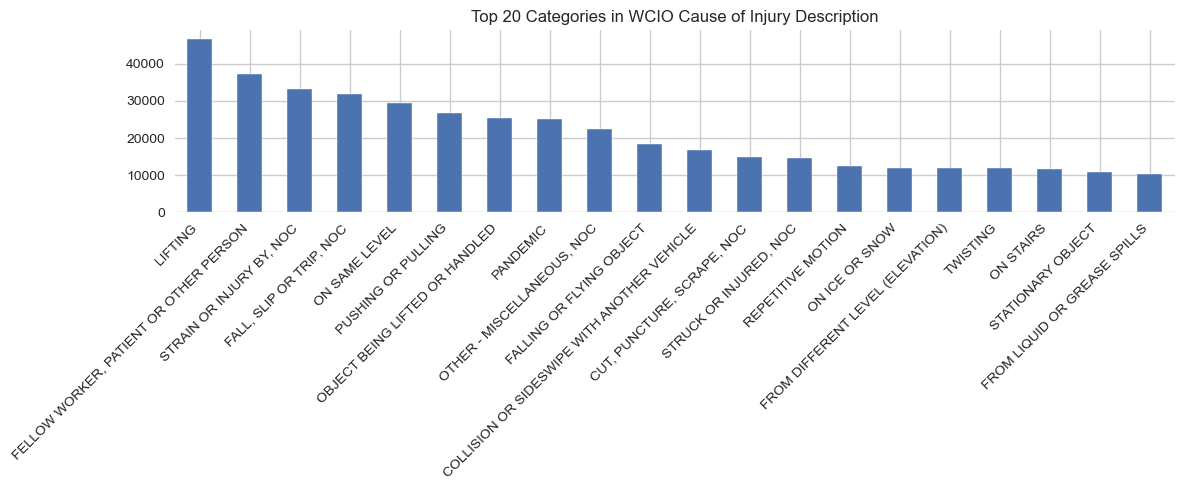

<Figure size 1200x600 with 0 Axes>

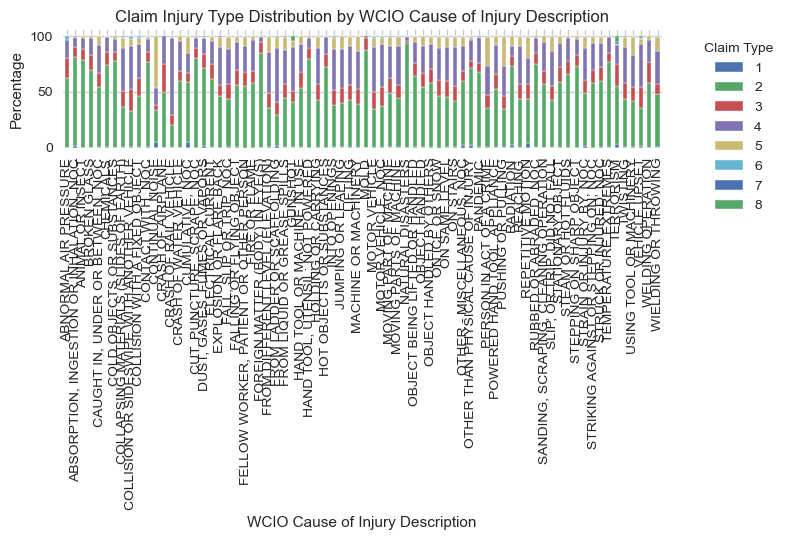


Analyzing WCIO Nature of Injury Description:
Number of unique values: 56

Top 10 most frequent values:
STRAIN OR TEAR                      153373
CONTUSION                           110717
SPRAIN OR TEAR                       55789
LACERATION                           47157
ALL OTHER SPECIFIC INJURIES, NOC     36101
COVID-19                             25724
FRACTURE                             22673
PUNCTURE                             17350
MULTIPLE PHYSICAL INJURIES ONLY      12734
INFLAMMATION                         12491
Name: WCIO Nature of Injury Description, dtype: int64


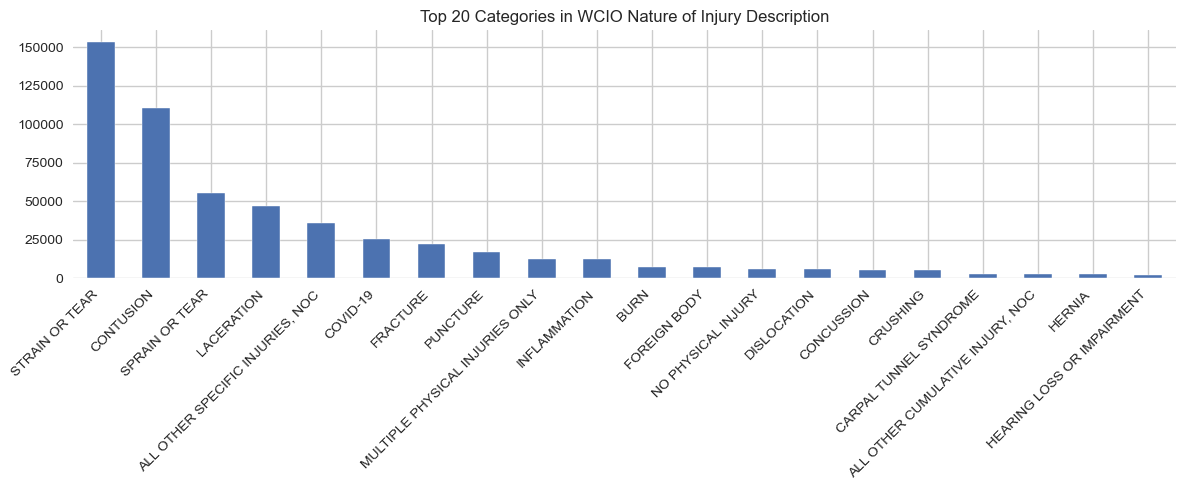

/var/folders/b9/bmsjjm2x30vcw342sbqf10xw0000gn/T/ipykernel_26735/1700799807.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

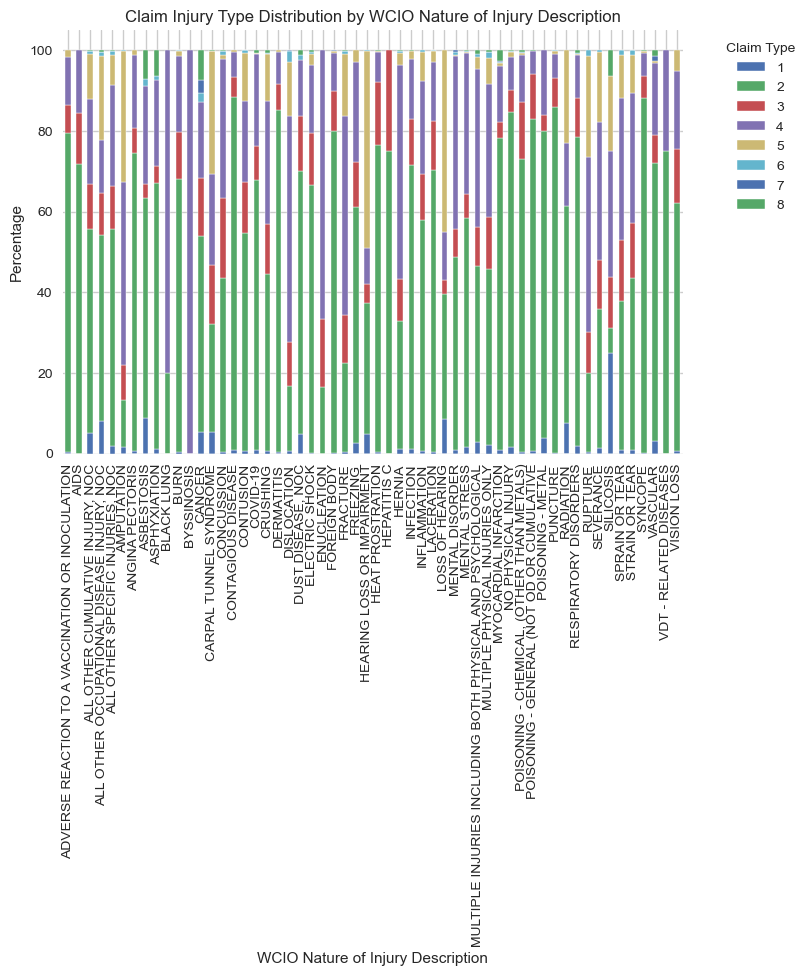


Analyzing WCIO Part Of Body Description:
Number of unique values: 54

Top 10 most frequent values:
LOWER BACK AREA                        51862
KNEE                                   47903
MULTIPLE                               42011
SHOULDER(S)                            37811
FINGER(S)                              36093
HAND                                   31388
ANKLE                                  24928
MULTIPLE BODY PARTS (INCLUDING BODY    22608
SOFT TISSUE                            19703
FOOT                                   18765
Name: WCIO Part Of Body Description, dtype: int64


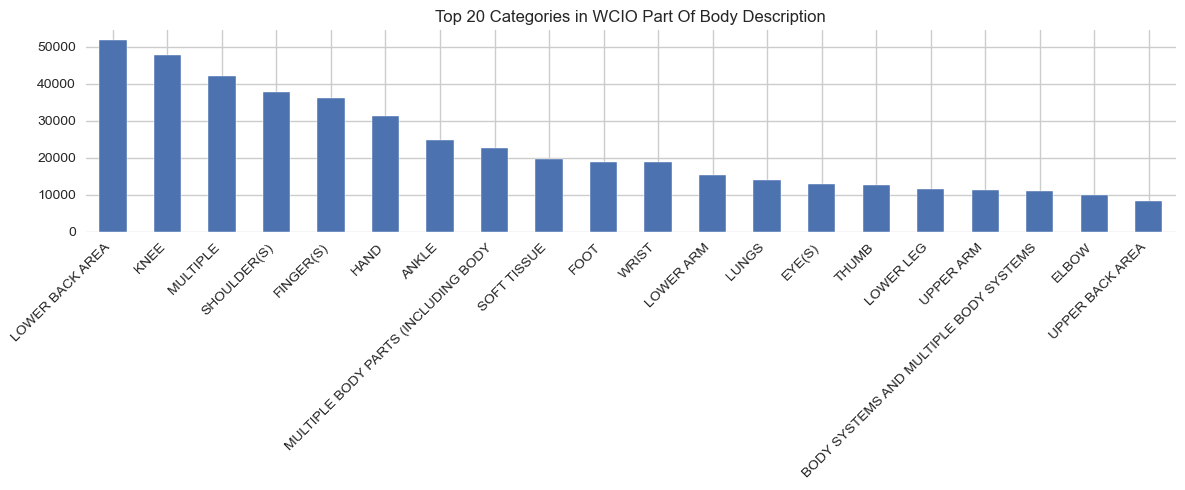

<Figure size 1200x600 with 0 Axes>

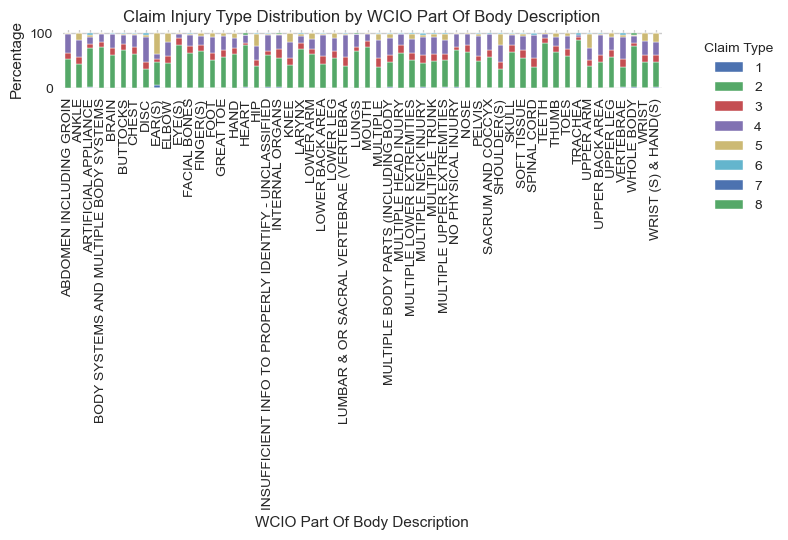


Analyzing Zip Code:
Number of unique values: 10060

Top 10 most frequent values:
11236    3302
10940    2971
11717    2807
11434    2759
11706    2728
11207    2633
11208    2559
11368    2553
12550    2530
11212    2504
Name: Zip Code, dtype: int64


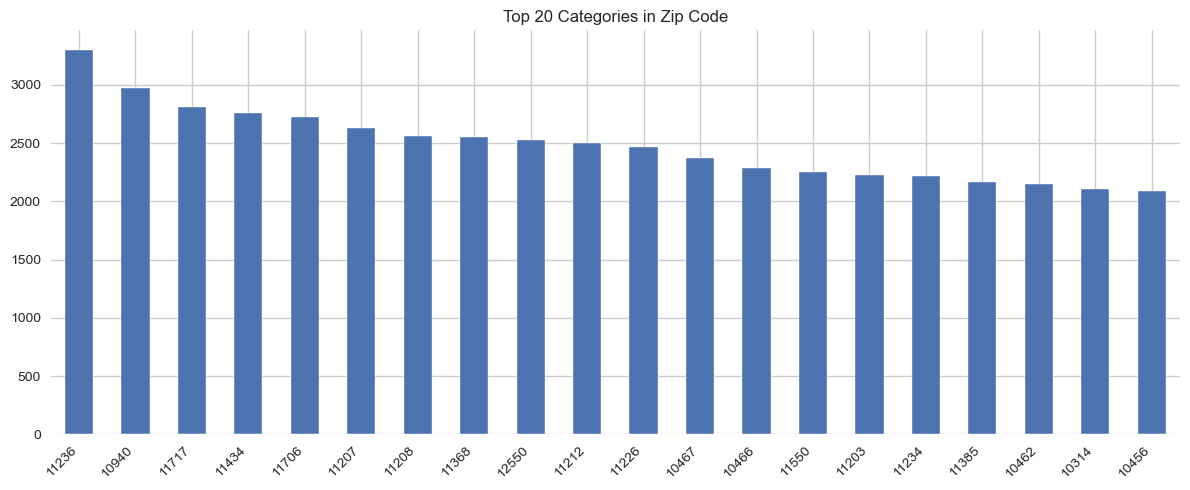

<Figure size 1200x600 with 0 Axes>

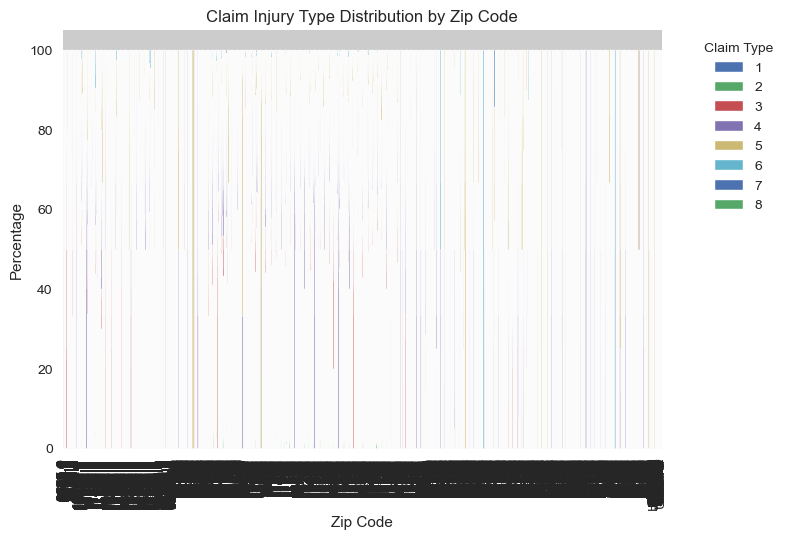


Analyzing WCB Decision:
Number of unique values: 1

Top 10 most frequent values:
Not Work Related    574026
Name: WCB Decision, dtype: int64


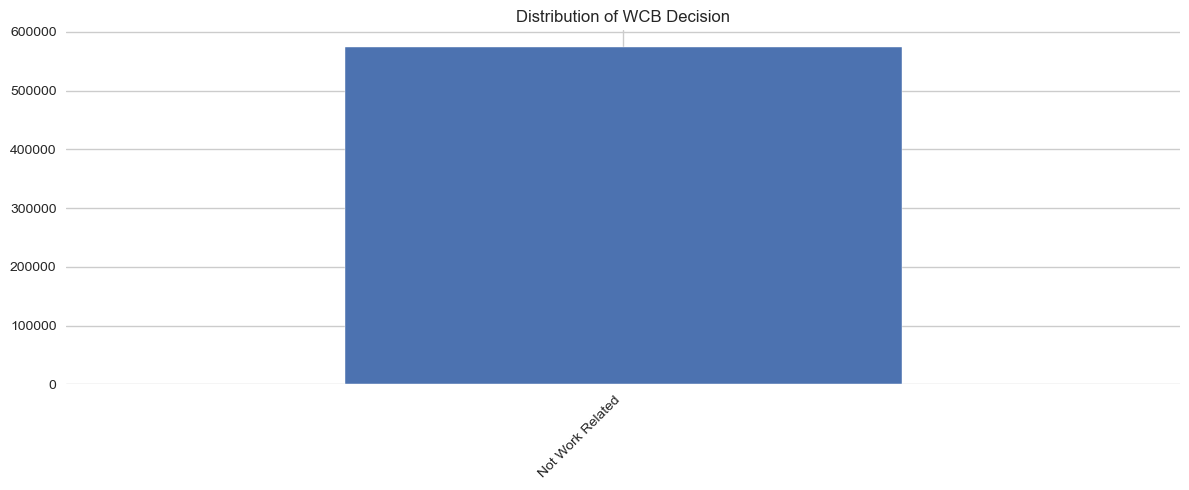

<Figure size 1200x600 with 0 Axes>

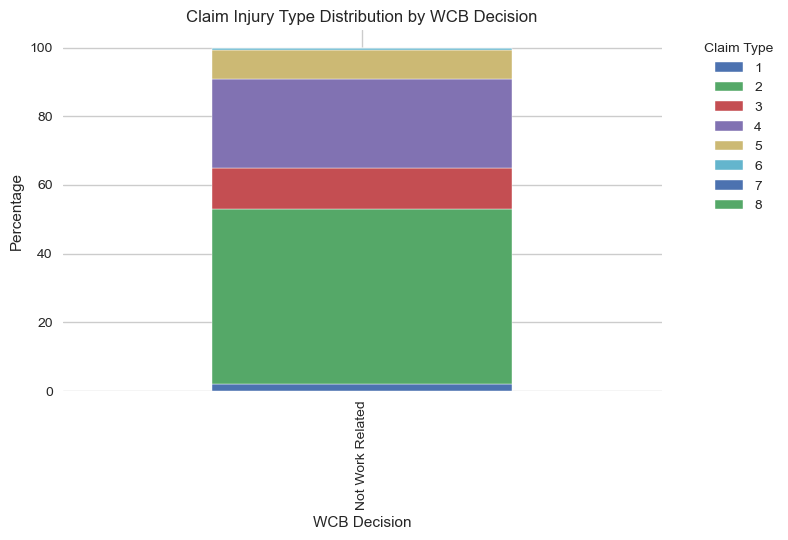

In [24]:
for col in categorical_cols:
    print(f"\nAnalyzing {col}:")
    
    # Value counts
    val_counts = train_df[col].value_counts()
    print(f"Number of unique values: {len(val_counts)}")
    print("\nTop 10 most frequent values:")
    print(val_counts.head(10))
    
    # Create visualization
    plt.figure(figsize=(12, 5))
    if len(val_counts) > 20:
        # For features with many categories, show top 20
        val_counts.head(20).plot(kind='bar')
        plt.title(f'Top 20 Categories in {col}')
    else:
        val_counts.plot(kind='bar')
        plt.title(f'Distribution of {col}')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Relationship with target
    pivot_table = pd.crosstab(train_df[col], train_df['Claim Injury Type Num'])
    pivot_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(12, 6))
    pivot_pct.plot(kind='bar', stacked=True)
    plt.title(f'Claim Injury Type Distribution by {col}')
    plt.xlabel(col)
    plt.ylabel('Percentage')
    plt.legend(title='Claim Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [25]:
date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], errors='coerce')
    test_df[col] = pd.to_datetime(test_df[col], errors='coerce')


Time difference between Assembly Date and Accident Date (days):
count    570337.000000
mean         82.227483
std         603.986690
min       -1127.000000
25%           5.000000
50%          10.000000
75%          24.000000
max       21503.000000
dtype: float64


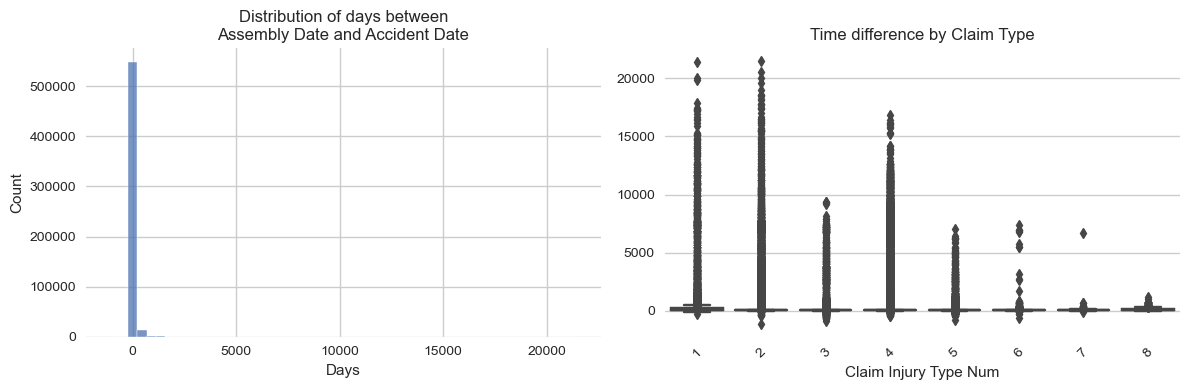


Time difference between C-2 Date and Accident Date (days):
count    557346.00000
mean         70.35153
std         511.63367
min       -8842.00000
25%           5.00000
50%          10.00000
75%          27.00000
max       21503.00000
dtype: float64


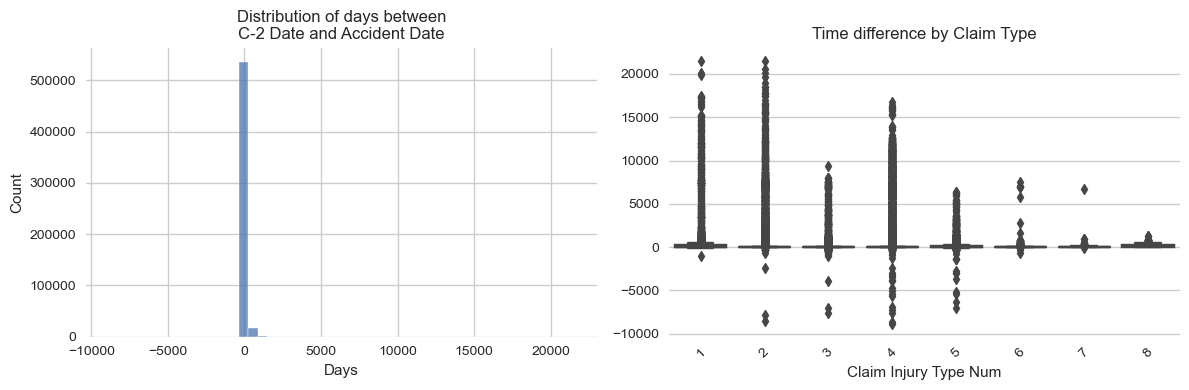


Time difference between C-3 Date and Accident Date (days):
count    183798.000000
mean         97.444298
std         406.096844
min       -9870.000000
25%          12.000000
50%          27.000000
75%          71.000000
max       18566.000000
dtype: float64


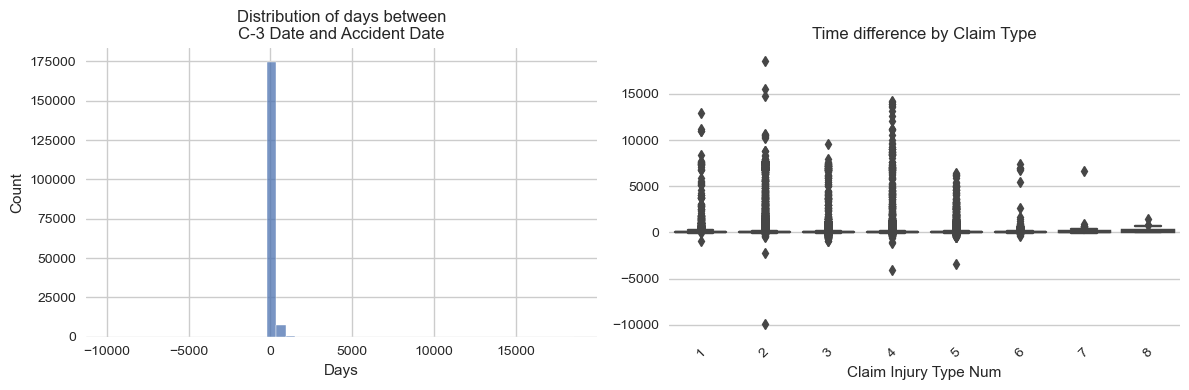


Time difference between First Hearing Date and Accident Date (days):
count    149347.000000
mean        335.081984
std         438.469419
min        -576.000000
25%         147.000000
50%         237.000000
75%         420.000000
max       16373.000000
dtype: float64


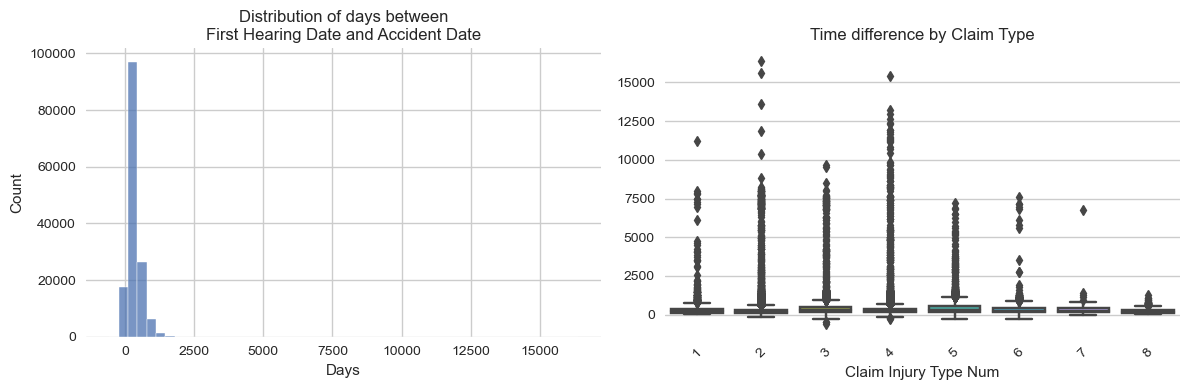


Time difference between C-2 Date and Assembly Date (days):
count    559466.000000
mean         -3.874555
std         259.318242
min       -9664.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1466.000000
dtype: float64


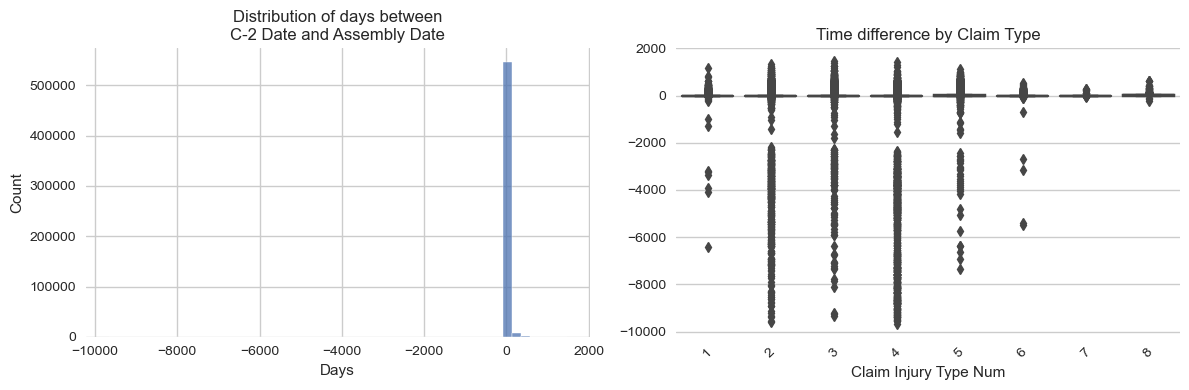


Time difference between C-3 Date and Assembly Date (days):
count    187245.000000
mean         31.867334
std         109.098058
min       -9939.000000
25%          -5.000000
50%           3.000000
75%          22.000000
max        1547.000000
dtype: float64


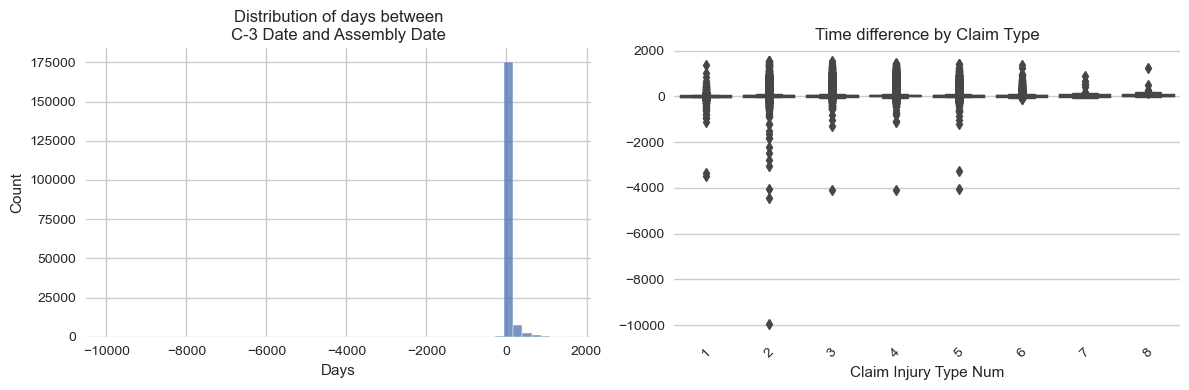


Time difference between First Hearing Date and Assembly Date (days):
count    150798.000000
mean        272.075936
std         221.497427
min           2.000000
25%         115.000000
50%         200.000000
75%         364.000000
max        1587.000000
dtype: float64


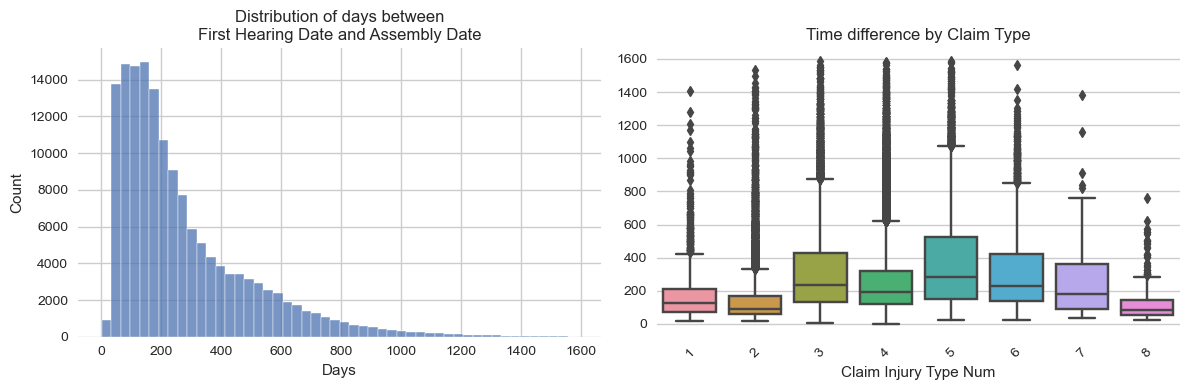


Time difference between C-3 Date and C-2 Date (days):
count    179041.000000
mean         14.407298
std         188.587252
min       -9943.000000
25%         -14.000000
50%           4.000000
75%          24.000000
max        9536.000000
dtype: float64


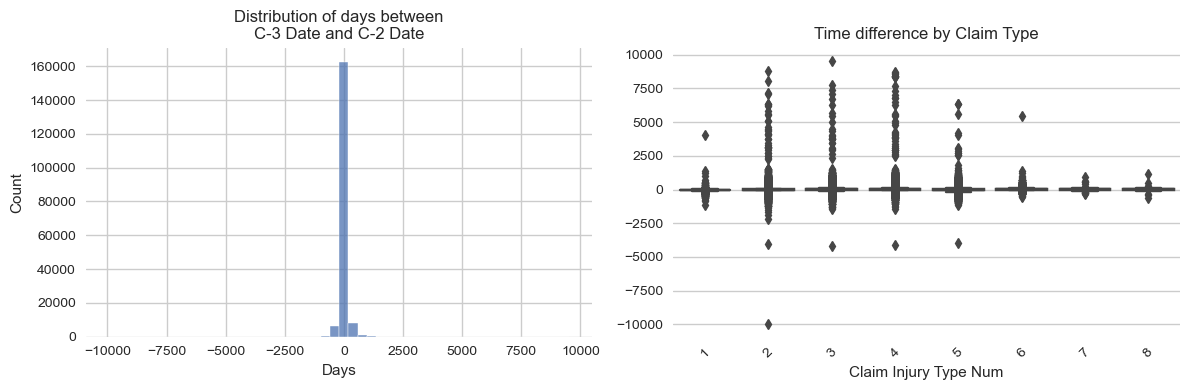


Time difference between First Hearing Date and C-2 Date (days):
count    149934.000000
mean        257.419178
std         281.763279
min       -1350.000000
25%          93.000000
50%         186.000000
75%         349.000000
max        9805.000000
dtype: float64


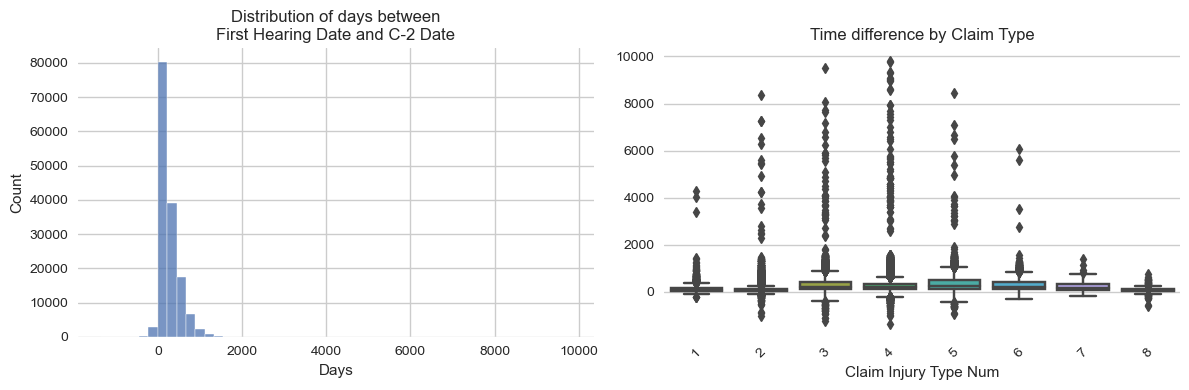


Time difference between First Hearing Date and C-3 Date (days):
count    109928.000000
mean        229.548095
std         219.908393
min       -1446.000000
25%          91.000000
50%         165.000000
75%         307.000000
max       10037.000000
dtype: float64


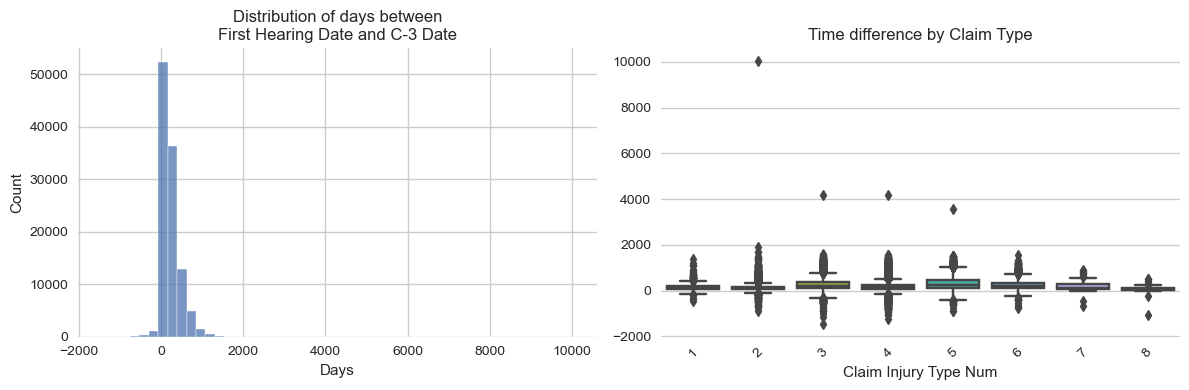

In [27]:
for i, col1 in enumerate(date_cols):
    for col2 in date_cols[i+1:]:
        diff = (train_df[col2] - train_df[col1]).dt.days
        
        print(f"\nTime difference between {col2} and {col1} (days):")
        print(diff.describe())
        
        plt.figure(figsize=(12, 4))
        
        # Distribution plot
        plt.subplot(1, 2, 1)
        sns.histplot(diff.dropna(), bins=50)
        plt.title(f'Distribution of days between\n{col2} and {col1}')
        plt.xlabel('Days')
        
        # Box plot by target
        plt.subplot(1, 2, 2)
        sns.boxplot(data=train_df, x='Claim Injury Type Num', y=diff)
        plt.title(f'Time difference by Claim Type')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

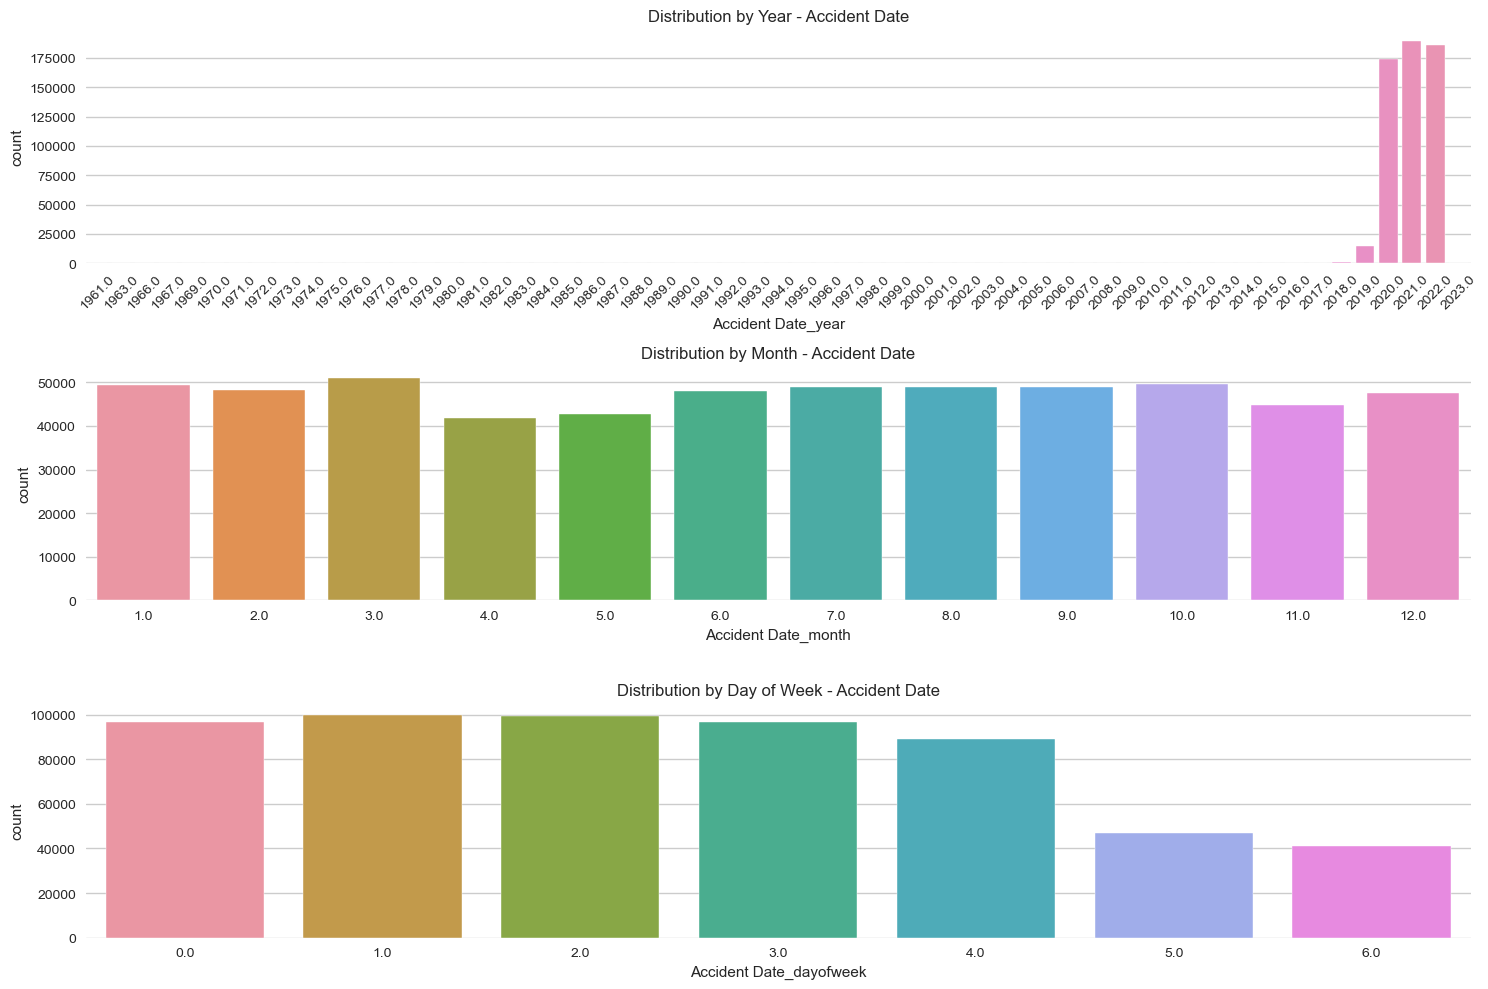

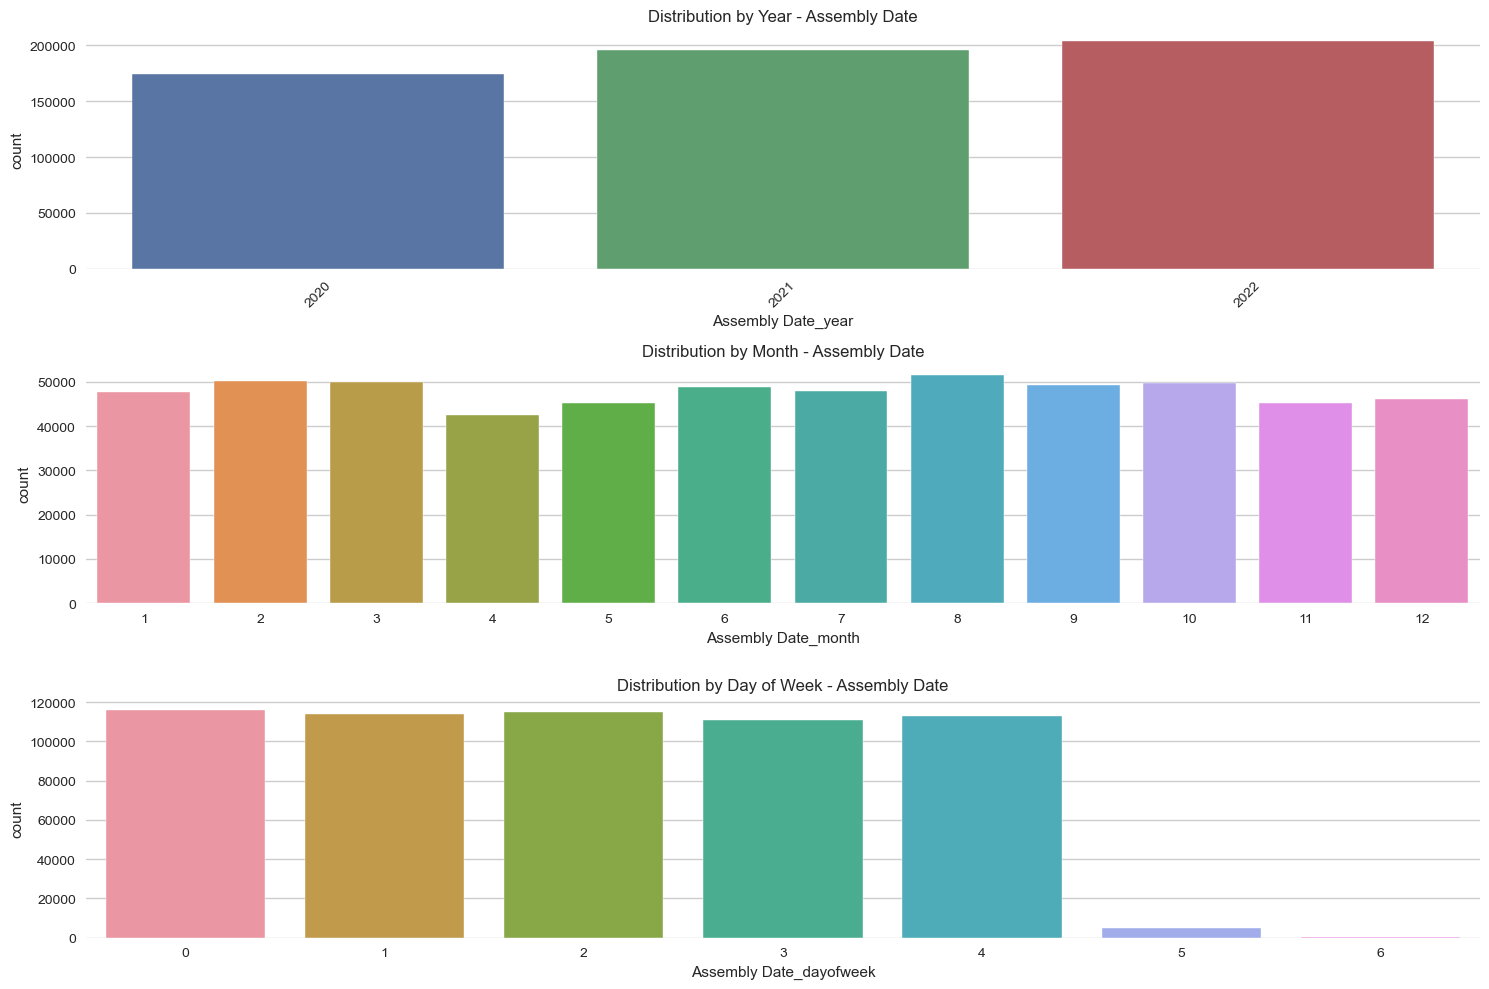

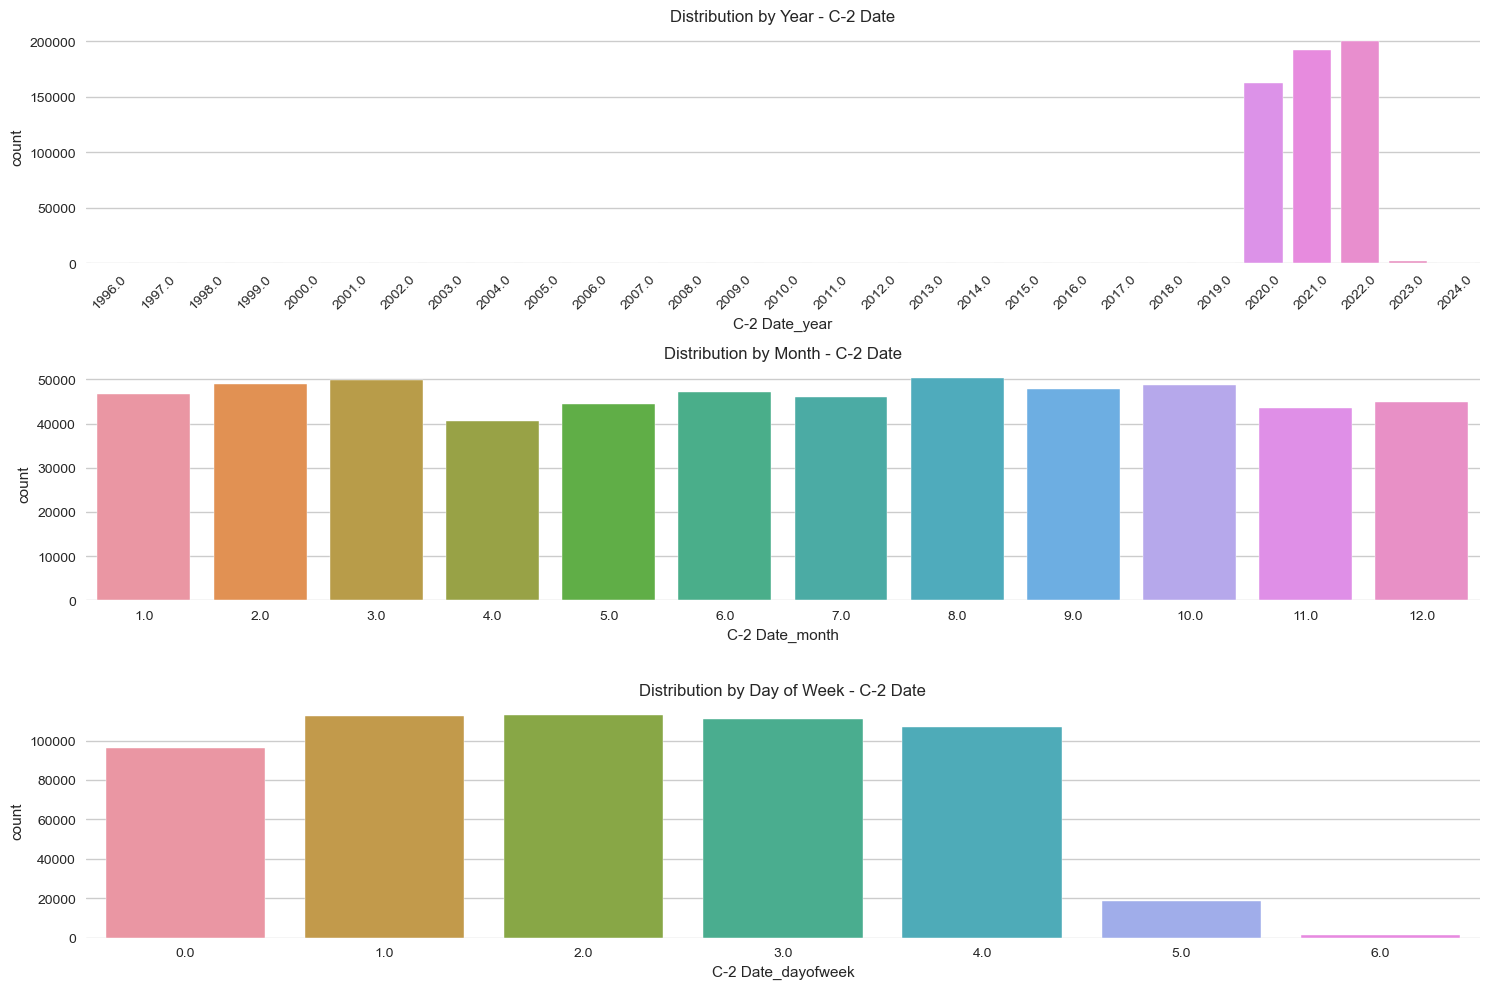

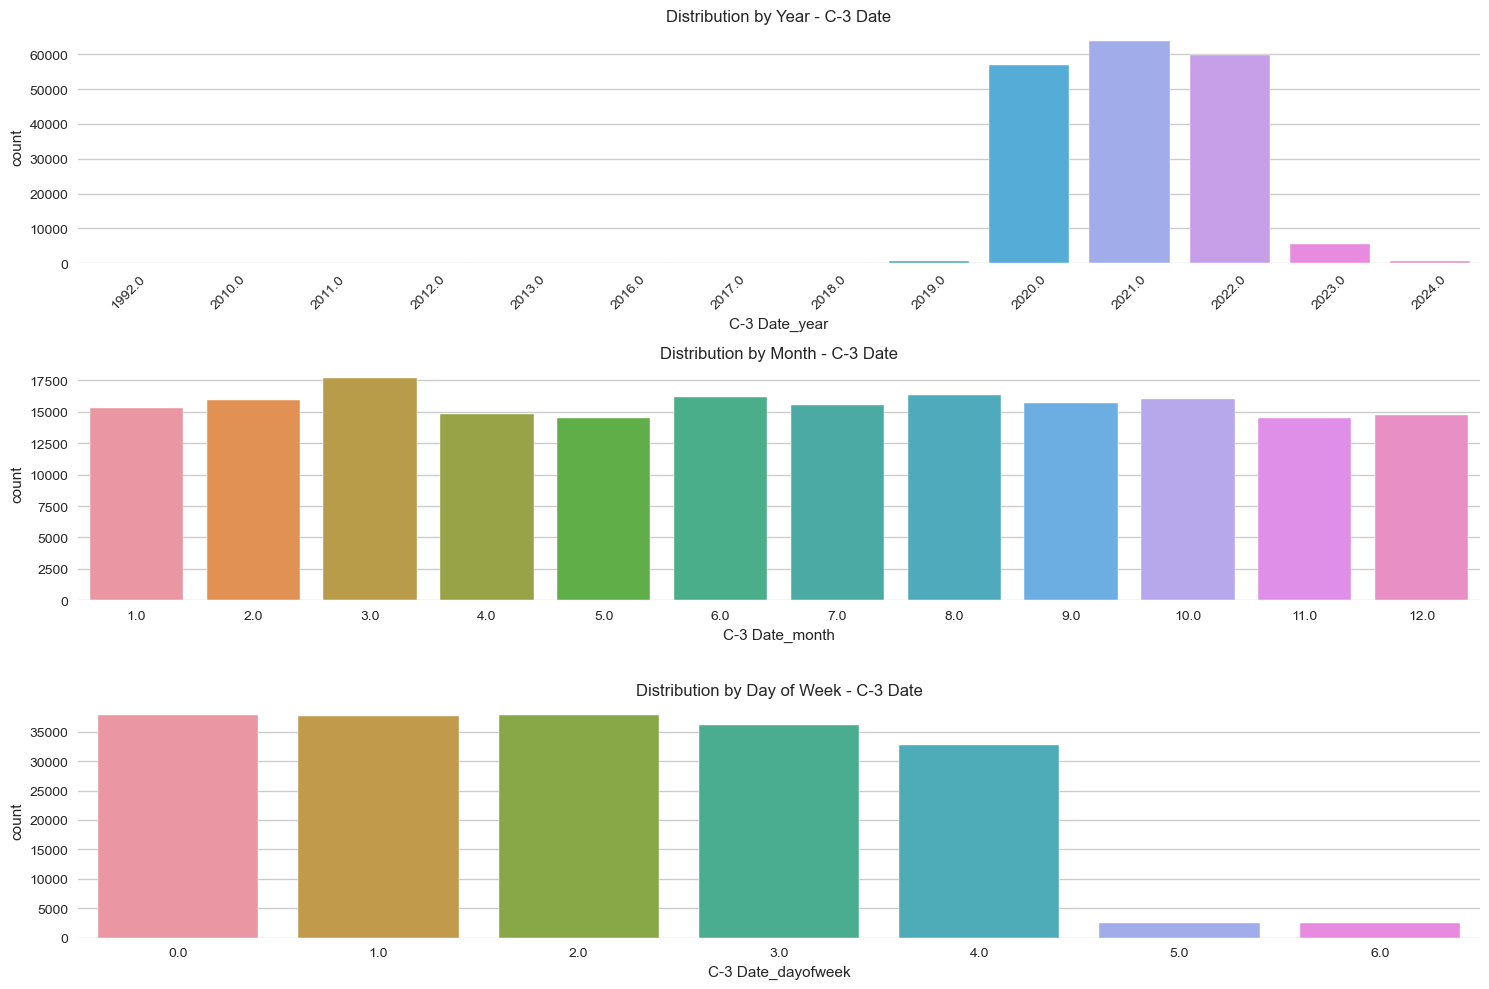

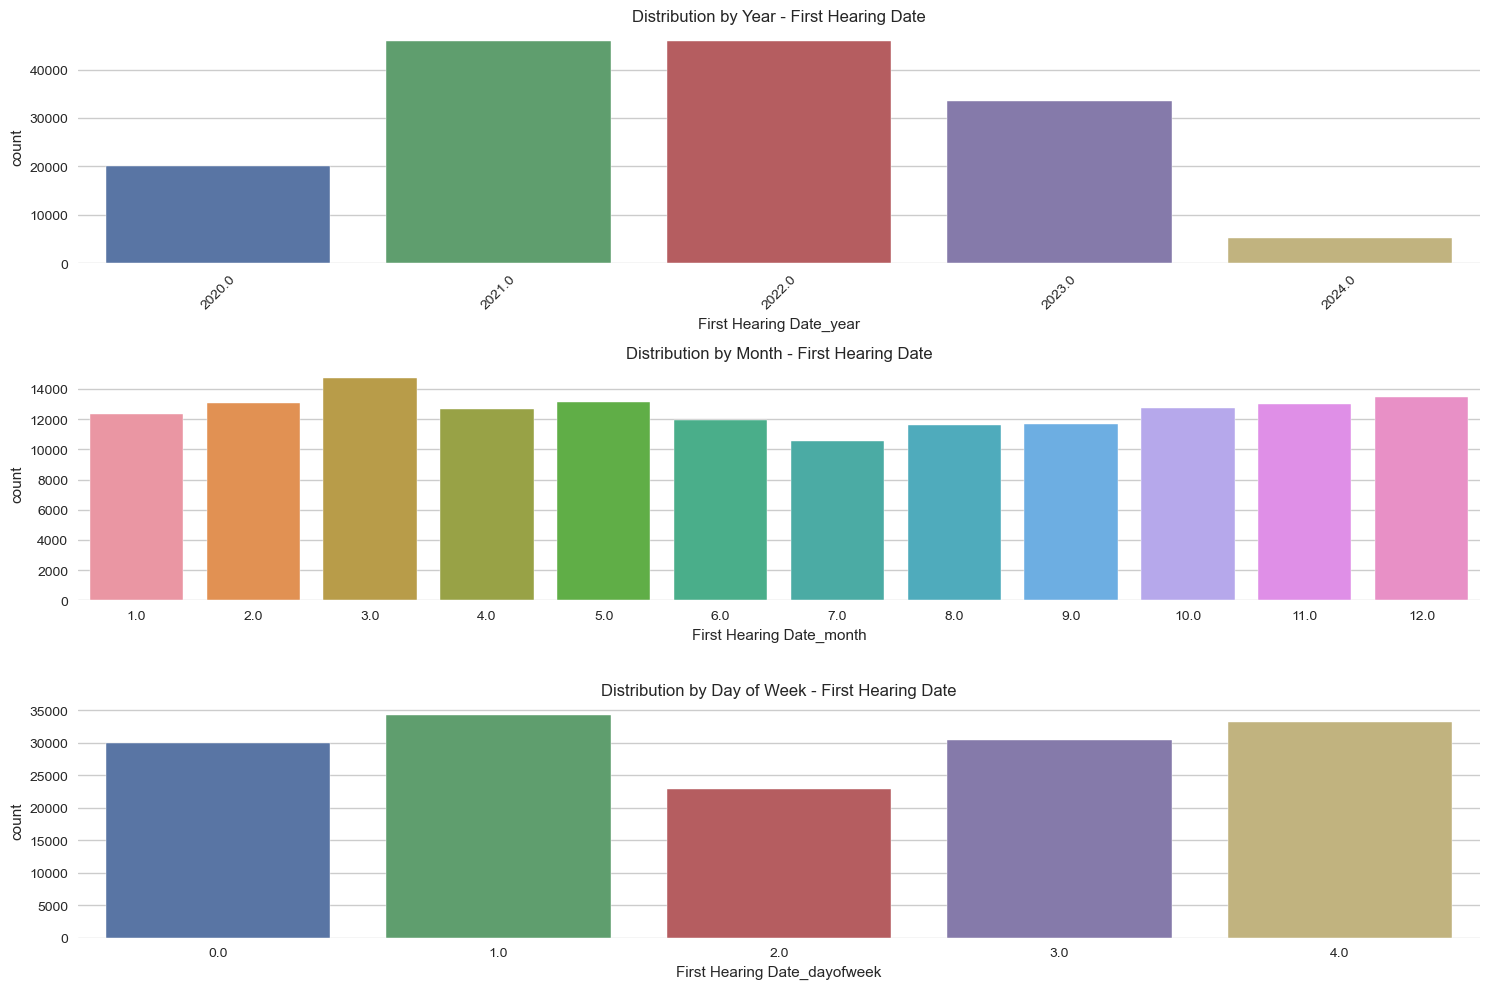

In [26]:
for col in date_cols:
    plt.figure(figsize=(15, 10))
    
    # Extract components
    train_df[f'{col}_year'] = train_df[col].dt.year
    train_df[f'{col}_month'] = train_df[col].dt.month
    train_df[f'{col}_dayofweek'] = train_df[col].dt.dayofweek
    
    # Year distribution
    plt.subplot(3, 1, 1)
    sns.countplot(data=train_df, x=f'{col}_year')
    plt.title(f'Distribution by Year - {col}')
    plt.xticks(rotation=45)
    
    # Month distribution
    plt.subplot(3, 1, 2)
    sns.countplot(data=train_df, x=f'{col}_month')
    plt.title(f'Distribution by Month - {col}')
    
    # Day of week distribution
    plt.subplot(3, 1, 3)
    sns.countplot(data=train_df, x=f'{col}_dayofweek')
    plt.title(f'Distribution by Day of Week - {col}')
    
    plt.tight_layout()
    plt.show()

Final shapes:
Train: (574026, 31)
Test: (387975, 30)


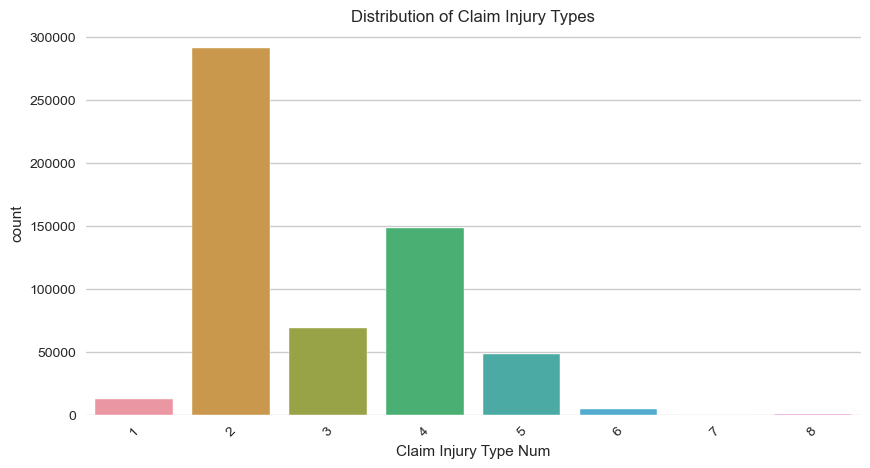

In [35]:
train_df_model = train_df_model.dropna(subset=['Claim Injury Type']).reset_index(drop=True)
train_df_model['Claim Injury Type Num'] = train_df_model['Claim Injury Type'].str.extract('^(\d+)').astype(int)

# Drop columns that won't be available for prediction
train_df_model = train_df_model.drop(columns=['WCB Decision', 'Claim Injury Type', 'Agreement Reached'])

print("Final shapes:")
print("Train:", train_df_model.shape)
print("Test:", test_df_model.shape)

# Quick look at target distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df_model, x='Claim Injury Type Num')
plt.title('Distribution of Claim Injury Types')
plt.xticks(rotation=45)
plt.show()

In [36]:
print("Train:", train_df_model.shape)
print("Test:", test_df_model.shape)

Train: (574026, 31)
Test: (387975, 30)


In [ ]:
def preprocess_dates(df, date_columns):
    """Process date columns with detailed info"""
    df = df.copy()
    print(f"Initial shape: {df.shape}")
    
    # Convert dates and create numeric versions
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[f'{col}_numeric'] = (df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
        
        # Extract components
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_dayofweek'] = df[col].dt.dayofweek
    
    # Calculate time differences
    df['Assembly_to_Accident'] = (df['Assembly Date'] - df['Accident Date']).dt.days
    df['C2_to_Accident'] = (df['C-2 Date'] - df['Accident Date']).dt.days
    df['C3_to_Accident'] = (df['C-3 Date'] - df['Accident Date']).dt.days
    df['Hearing_to_Accident'] = (df['First Hearing Date'] - df['Accident Date']).dt.days
    
    # Drop original date columns
    df = df.drop(columns=date_columns)
    
    print(f"Shape after date processing: {df.shape}")
    return df

In [37]:
def preprocess_dates(df, date_columns):
    """Process date columns with detailed info"""
    df = df.copy()
    print(f"Initial shape: {df.shape}")
    
    # Convert dates and create numeric versions
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[f'{col}_numeric'] = (df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
        
        # Extract components
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_dayofweek'] = df[col].dt.dayofweek
    
    # Calculate time differences
    df['Assembly_to_Accident'] = (df['Assembly Date'] - df['Accident Date']).dt.days
    df['C2_to_Accident'] = (df['C-2 Date'] - df['Accident Date']).dt.days
    df['C3_to_Accident'] = (df['C-3 Date'] - df['Accident Date']).dt.days
    df['Hearing_to_Accident'] = (df['First Hearing Date'] - df['Accident Date']).dt.days
    
    # Drop original date columns
    df = df.drop(columns=date_columns)
    
    print(f"Shape after date processing: {df.shape}")
    return df

In [38]:
def create_feature_sets(df, feature_set='basic'):
    """Create different feature sets"""
    df = df.copy()
    
    if feature_set == 'basic':
        return df
    
    # Create binned categories for continuous variables
    if 'Age at Injury' in df.columns:
        df['Age_Group'] = pd.qcut(
            df['Age at Injury'].fillna(df['Age at Injury'].median()),
            q=5, 
            labels=['VeryYoung', 'Young', 'Middle', 'Old', 'VeryOld']
        )
    
    if 'Average Weekly Wage' in df.columns:
        df['Wage_Group'] = pd.qcut(
            df['Average Weekly Wage'].fillna(df['Average Weekly Wage'].median()),
            q=5,
            labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
        )
    
    if feature_set in ['interactions', 'full']:
        # Create interaction features
        df['Carrier_Industry'] = df['Carrier Type'].astype(str) + '_' + df['Industry Code'].astype(str)
        df['District_County'] = df['District Name'].astype(str) + '_' + df['County of Injury'].astype(str)
        
        # Create missing indicators
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                df[f'{col}_missing'] = df[col].isnull().astype(int)
    
    return df

In [57]:
def handle_missing_values(train_df, test_df, strategy='median'):
    """Handle missing values in both datasets"""
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Separate numerical and categorical columns
    numeric_cols = train_df.select_dtypes(include=['number']).columns
    numeric_cols = [col for col in numeric_cols if col != 'Claim Injury Type Num']
    categorical_cols = train_df.select_dtypes(include=['object']).columns
    
    print(f"Number of numeric columns: {len(numeric_cols)}")
    print(f"Number of categorical columns: {len(categorical_cols)}")
    
    # Handle categorical variables
    label_encoders = {}
    for col in categorical_cols:
        print(f"\nProcessing {col}")
        # Convert to string and fill missing values in both train and test
        train_df[col] = train_df[col].astype(str).fillna('MISSING')
        test_df[col] = test_df[col].astype(str).fillna('MISSING')
        
        # Initialize encoder
        le = LabelEncoder()
        
        # Fit on combined unique values to ensure all categories are known
        unique_values = pd.concat([
            train_df[col].astype(str), 
            test_df[col].astype(str)
        ]).unique()
        
        le.fit(unique_values)
        
        # Transform both datasets
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        
        label_encoders[col] = le
    
    # Handle numeric variables
    print("\nProcessing numeric columns...")
    if strategy == 'knn':
        imputer = KNNImputer(n_neighbors=5)
        if len(numeric_cols) > 0:
            train_df[numeric_cols] = imputer.fit_transform(train_df[numeric_cols])
            test_df[numeric_cols] = imputer.transform(test_df[numeric_cols])
    else:
        for col in numeric_cols:
            fill_value = train_df[col].median() if strategy == 'median' else train_df[col].mean()
            train_df[col].fillna(fill_value, inplace=True)
            test_df[col].fillna(fill_value, inplace=True)
    
    # Final check for any remaining NaN values
    if train_df.isnull().any().any() or test_df.isnull().any().any():
        print("\nWarning: NaN values remain after initial processing")
        # Fill any remaining NaN values with 0
        train_df = train_df.fillna(0)
        test_df = test_df.fillna(0)
    
    return train_df, test_df, label_encoders

In [58]:
def scale_numeric_features(train_df, test_df, strategy='standard'):
    """Scale numeric features"""
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    numeric_cols = train_df.select_dtypes(include=['number']).columns
    numeric_cols = [col for col in numeric_cols if col != 'Claim Injury Type Num']
    
    if len(numeric_cols) > 0:
        if strategy == 'standard':
            scaler = StandardScaler()
        elif strategy == 'minmax':
            scaler = MinMaxScaler()
        elif strategy == 'robust':
            scaler = RobustScaler()
        
        # Fill any NaN values before scaling
        train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].mean())
        test_df[numeric_cols] = test_df[numeric_cols].fillna(train_df[numeric_cols].mean())
        
        train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
        test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
    
    return train_df, test_df, scaler

In [59]:
def check_data_quality(df, name="Dataset"):
    """Check data quality and print diagnostics"""
    print(f"\nChecking {name}:")
    print(f"Shape: {df.shape}")
    
    # Check for NaN values
    nulls = df.isnull().sum()
    if nulls.any():
        print("\nColumns with NaN values:")
        print(nulls[nulls > 0])
    
    # Check for infinite values
    inf_cols = df.isin([np.inf, -np.inf]).any()
    if inf_cols.any():
        print("\nColumns with infinite values:")
        print(inf_cols[inf_cols])
    
    # Basic statistics for numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        print("\nNumeric columns statistics:")
        print(df[numeric_cols].describe())

In [60]:
def run_preprocessing_pipeline(train_df, test_df,
                             feature_set='basic',
                             imputation_strategy='median',
                             scaling_strategy='standard'):
    """Complete preprocessing pipeline"""
    print("\nStarting preprocessing pipeline:")
    print(f"Feature set: {feature_set}")
    print(f"Imputation: {imputation_strategy}")
    print(f"Scaling: {scaling_strategy}")
    
    # Initial quality check
    check_data_quality(train_df, "Initial training data")
    check_data_quality(test_df, "Initial test data")
    
    date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
    
    # Process dates
    print("\nProcessing dates...")
    train_df = preprocess_dates(train_df, date_cols)
    test_df = preprocess_dates(test_df, date_cols)
    
    # Create features
    print("\nCreating features...")
    train_df = create_feature_sets(train_df, feature_set)
    test_df = create_feature_sets(test_df, feature_set)
    
    # Handle missing values
    print("\nHandling missing values...")
    train_df, test_df, label_encoders = handle_missing_values(
        train_df, test_df, imputation_strategy
    )
    # Scale features
    print("\nScaling features...")
    train_df, test_df, scaler = scale_numeric_features(
        train_df, test_df, scaling_strategy
    )
    
    print("\nPreprocessing complete!")
    print("Train shape:", train_df.shape)
    print("Test shape:", test_df.shape)
    
    check_data_quality(train_df, "Final training data")
    check_data_quality(test_df, "Final test data")
    
    return train_df, test_df, label_encoders, scaler

In [69]:
def prepare_modeling_data(train_df, test_df, random_state=42):
    """Prepare data for modeling, including train/validation split"""
    # Make a copy to avoid modifying originals
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Adjust target to be zero-based for XGBoost
    y = train_df['Claim Injury Type Num'] - 1  # Subtract 1 to make it 0-based
    X = train_df.drop('Claim Injury Type Num', axis=1)
    
    # Create train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    
    return X_train, X_val, y_train, y_val, test_df

In [71]:
def train_model(X_train, y_train, model_type='xgb', random_state=42):
    """Train model with multiple options"""
    print(f"\nTraining {model_type} model...")
    print(f"Starting training with {X_train.shape[1]} features...")
    
    if model_type == 'xgb':
        model = XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=random_state,
            n_jobs=2,
            tree_method='hist',
            enable_categorical=True,
            objective='multi:softprob',
            num_class=8,
            eval_metric=['mlogloss', 'merror'],
            use_label_encoder=False
        )
        
        # Train with early stopping
        eval_set = [(X_train, y_train)]
        model.fit(
            X_train, y_train,
            eval_set=eval_set,
            early_stopping_rounds=10,
            verbose=True
        )
        
    elif model_type == 'hist_gb':
        model = HistGradientBoostingClassifier(
            max_iter=100,
            learning_rate=0.1,
            max_depth=None,
            random_state=random_state,
            verbose=1
        )
        model.fit(X_train, y_train)
        
    elif model_type == 'simple_rf':
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=random_state,
            n_jobs=2,
            verbose=1
        )
        model.fit(X_train, y_train)
        
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    return model
 

In [44]:
def evaluate_model(model, X_val, y_val, X_test=None):
    """Evaluate model performance and generate predictions"""
    # Validation predictions
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'f1_macro': f1_score(y_val, y_val_pred, average='macro')
    }
    
    # Print detailed validation results
    print("\nValidation Results:")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nMetrics:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Generate test predictions if test data is provided
    test_pred = None
    if X_test is not None:
        test_pred = model.predict(X_test)
    
    return val_metrics, test_pred

In [70]:
def create_submission(predictions, test_df, experiment_name):
    """Create submission file with adjusted predictions"""
    # Add 1 back to predictions to match original scale
    submission = pd.DataFrame({
        'Claim Identifier': test_df['Claim Identifier'],
        'Claim Injury Type': predictions + 1  # Add 1 to convert back to original scale
    })
    
    filename = f'submission_{experiment_name}.csv'
    submission.to_csv(filename, index=False)
    print(f"\nSubmission saved to {filename}")
    
    return submission

In [46]:
def run_experiment(train_df, test_df, experiment_config):
    """Run complete experiment including preprocessing and modeling"""
    print(f"\nRunning experiment: {experiment_config['name']}")
    print("=" * 50)
    
    # Run preprocessing pipeline
    train_processed, test_processed, label_encoders, scaler = run_preprocessing_pipeline(
        train_df,
        test_df,
        feature_set=experiment_config['feature_set'],
        imputation_strategy=experiment_config['imputation_strategy'],
        scaling_strategy=experiment_config['scaling_strategy']
    )
    
    # Prepare modeling data
    X_train, X_val, y_train, y_val, test_df = prepare_modeling_data(
        train_processed, 
        test_processed
    )
    # Train model
    print("\nTraining model...")
    model = train_model(
        X_train, 
        y_train,
        model_type=experiment_config.get('model_type', 'rf')
    )
    
    # Evaluate model and get predictions
    print("\nEvaluating model...")
    val_metrics, test_pred = evaluate_model(
        model, 
        X_val, 
        y_val, 
        test_processed
    )
    
    # Create submission
    submission = create_submission(
        test_pred,
        test_df,
        experiment_config['name']
    )
    # Store all experiment results
    results = {
        'config': experiment_config,
        'model': model,
        'metrics': val_metrics,
        'label_encoders': label_encoders,
        'scaler': scaler,
        'feature_names': X_train.columns.tolist(),
        'submission': submission
    }
    
    return results

In [47]:
def run_multiple_experiments(train_df, test_df, experiments):
    """Run multiple experiments and compare results"""
    results = {}
    metrics_comparison = []
    
    for exp_config in experiments:
        # Run experiment
        exp_results = run_experiment(train_df, test_df, exp_config)
        
        # Store results
        results[exp_config['name']] = exp_results
        
        # Store metrics for comparison
        metrics_comparison.append({
            'experiment': exp_config['name'],
            **exp_results['metrics'],
            'feature_set': exp_config['feature_set'],
            'imputation': exp_config['imputation_strategy'],
            'scaling': exp_config['scaling_strategy']
        })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(metrics_comparison)
    
    print("\nExperiment Comparison:")
    print(comparison_df.sort_values('f1_macro', ascending=False))
    
    return results, comparison_df


In [72]:
experiments = [
    {
        'name': 'basic_xgb',
        'feature_set': 'basic',
        'imputation_strategy': 'median',
        'scaling_strategy': 'standard',
        'model_type': 'xgb'
    },
    {
        'name': 'basic_hist_gb',
        'feature_set': 'basic',
        'imputation_strategy': 'median',
        'scaling_strategy': 'standard',
        'model_type': 'hist_gb'
    },
    {
        'name': 'basic_rf',
        'feature_set': 'basic',
        'imputation_strategy': 'median',
        'scaling_strategy': 'standard',
        'model_type': 'simple_rf'
    }
]

In [67]:
def analyze_feature_importance(model, feature_names, top_n=20):
    """Analyze feature importance for XGBoost model"""
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        })
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        # Plot top N features
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=importance_df.head(top_n),
            x='importance',
            y='feature'
        )
        plt.title(f'Top {top_n} Most Important Features')
        plt.tight_layout()
        plt.show()
        
        return importance_df


Running experiment: basic_xgb

Starting preprocessing pipeline:
Feature set: basic
Imputation: median
Scaling: standard

Checking Initial training data:
Shape: (574026, 31)

Columns with NaN values:
Accident Date                           3689
Average Weekly Wage                    28651
Birth Year                             29078
C-2 Date                               14560
C-3 Date                              386781
First Hearing Date                    423228
IME-4 Count                           441223
Industry Code                           9958
Industry Code Description               9958
OIICS Nature of Injury Description    574026
WCIO Cause of Injury Code              15640
WCIO Cause of Injury Description       15640
WCIO Nature of Injury Code             15657
WCIO Nature of Injury Description      15657
WCIO Part Of Body Code                 17082
WCIO Part Of Body Description          17082
Zip Code                               28637
dtype: int64

Numeric columns stati

       Age at Injury  Alternative Dispute Resolution  Attorney/Representative  \
count  387975.000000                   387975.000000            387975.000000   
mean       -0.049053                       -0.004006                -0.229033   
std         1.017160                        0.970218                 0.875748   
min        -2.954057                       -0.067620                -0.680636   
25%        -0.849741                       -0.067620                -0.680636   
50%        -0.148303                       -0.067620                -0.680636   
75%         0.763567                       -0.067620                -0.680636   
max         5.042341                       14.795684                 1.469213   

       Average Weekly Wage     Birth Year   Carrier Name   Carrier Type  \
count        387975.000000  387975.000000  387975.000000  387975.000000   
mean             -0.049211      -0.026837      -0.032451      -0.008376   
std               0.581453       1.072773    

/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.84415	validation_0-merror:0.22715
[1]	validation_0-mlogloss:1.67469	validation_0-merror:0.22619
[2]	validation_0-mlogloss:1.54235	validation_0-merror:0.22657
[3]	validation_0-mlogloss:1.43424	validation_0-merror:0.22568
[4]	validation_0-mlogloss:1.34395	validation_0-merror:0.22542
[5]	validation_0-mlogloss:1.26695	validation_0-merror:0.22504
[6]	validation_0-mlogloss:1.20013	validation_0-merror:0.22477
[7]	validation_0-mlogloss:1.14224	validation_0-merror:0.22401
[8]	validation_0-mlogloss:1.09084	validation_0-merror:0.22298
[9]	validation_0-mlogloss:1.04575	validation_0-merror:0.22203
[10]	validation_0-mlogloss:1.00573	validation_0-merror:0.22175
[11]	validation_0-mlogloss:0.97010	validation_0-merror:0.22149
[12]	validation_0-mlogloss:0.93813	validation_0-merror:0.22086
[13]	validation_0-mlogloss:0.90942	validation_0-merror:0.22045
[14]	validation_0-mlogloss:0.88366	validation_0-merror:0.22006
[15]	validation_0-mlogloss:0.86049	validation_0-merror:0.21959
[1

/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Submission saved to submission_basic_xgb.csv

Running experiment: basic_hist_gb

Starting preprocessing pipeline:
Feature set: basic
Imputation: median
Scaling: standard

Checking Initial training data:
Shape: (574026, 31)

Columns with NaN values:
Accident Date                           3689
Average Weekly Wage                    28651
Birth Year                             29078
C-2 Date                               14560
C-3 Date                              386781
First Hearing Date                    423228
IME-4 Count                           441223
Industry Code                           9958
Industry Code Description               9958
OIICS Nature of Injury Description    574026
WCIO Cause of Injury Code              15640
WCIO Cause of Injury Description       15640
WCIO Nature of Injury Code             15657
WCIO Nature of Injury Description      15657
WCIO Part Of Body Code                 17082
WCIO Part Of Body Description          17082
Zip Code                      

       Age at Injury  Alternative Dispute Resolution  Attorney/Representative  \
count  387975.000000                   387975.000000            387975.000000   
mean       -0.049053                       -0.004006                -0.229033   
std         1.017160                        0.970218                 0.875748   
min        -2.954057                       -0.067620                -0.680636   
25%        -0.849741                       -0.067620                -0.680636   
50%        -0.148303                       -0.067620                -0.680636   
75%         0.763567                       -0.067620                -0.680636   
max         5.042341                       14.795684                 1.469213   

       Average Weekly Wage     Birth Year   Carrier Name   Carrier Type  \
count        387975.000000  387975.000000  387975.000000  387975.000000   
mean             -0.049211      -0.026837      -0.032451      -0.008376   
std               0.581453       1.072773    

Binning 0.162 GB of training data: 0.763 s
Binning 0.018 GB of validation data: 0.047 s
Fitting gradient boosted rounds:
[1/100] 8 trees, 248 leaves (31 on avg), max depth = 11, train loss: 1.14080, val loss: 1.15566, in 0.540s
[2/100] 8 trees, 248 leaves (31 on avg), max depth = 11, train loss: 1.19008, val loss: 1.20126, in 0.548s
[3/100] 8 trees, 248 leaves (31 on avg), max depth = 15, train loss: 1.41280, val loss: 1.42371, in 0.586s
[4/100] 8 trees, 248 leaves (31 on avg), max depth = 14, train loss: 1.53107, val loss: 1.32568, in 0.598s
[5/100] 8 trees, 248 leaves (31 on avg), max depth = 14, train loss: 1.66831, val loss: 1.38513, in 0.320s
[6/100] 8 trees, 248 leaves (31 on avg), max depth = 15, train loss: 1.66482, val loss: 1.39682, in 0.514s
[7/100] 8 trees, 248 leaves (31 on avg), max depth = 12, train loss: 1.52836, val loss: 1.31635, in 0.660s
[8/100] 8 trees, 248 leaves (31 on avg), max depth = 13, train loss: 1.58913, val loss: 1.40608, in 0.574s
[9/100] 8 trees, 248 le

Shape after date processing: (574026, 50)
Initial shape: (387975, 30)
Shape after date processing: (387975, 49)

Creating features...

Handling missing values...
Number of numeric columns: 35
Number of categorical columns: 14

Processing Alternative Dispute Resolution

Processing Attorney/Representative

Processing Carrier Name

Processing Carrier Type

Processing County of Injury

Processing COVID-19 Indicator

Processing District Name

Processing Gender

Processing Industry Code Description

Processing Medical Fee Region

Processing WCIO Cause of Injury Description

Processing WCIO Nature of Injury Description

Processing WCIO Part Of Body Description

Processing Zip Code

Processing numeric columns...


Scaling features...

Preprocessing complete!
Train shape: (574026, 50)
Test shape: (387975, 49)

Checking Final training data:
Shape: (574026, 50)

Numeric columns statistics:
       Age at Injury  Alternative Dispute Resolution  Attorney/Representative  \
count   5.740260e+05       

       Age at Injury  Alternative Dispute Resolution  Attorney/Representative  \
count  387975.000000                   387975.000000            387975.000000   
mean       -0.049053                       -0.004006                -0.229033   
std         1.017160                        0.970218                 0.875748   
min        -2.954057                       -0.067620                -0.680636   
25%        -0.849741                       -0.067620                -0.680636   
50%        -0.148303                       -0.067620                -0.680636   
75%         0.763567                       -0.067620                -0.680636   
max         5.042341                       14.795684                 1.469213   

       Average Weekly Wage     Birth Year   Carrier Name   Carrier Type  \
count        387975.000000  387975.000000  387975.000000  387975.000000   
mean             -0.049211      -0.026837      -0.032451      -0.008376   
std               0.581453       1.072773    

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   26.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



Evaluating model...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunosousa/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predic


Validation Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.47      0.57      2452
           1       0.84      0.98      0.91     58418
           2       0.58      0.04      0.08     13749
           3       0.68      0.91      0.78     29682
           4       0.78      0.34      0.48      9585
           5       0.00      0.00      0.00       815
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        91

    accuracy                           0.78    114806
   macro avg       0.45      0.34      0.35    114806
weighted avg       0.75      0.78      0.72    114806


Metrics:
accuracy: 0.7801
f1_macro: 0.3521


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished



Submission saved to submission_basic_rf.csv

Experiment Comparison:
      experiment  accuracy  f1_macro feature_set imputation   scaling
0      basic_xgb  0.790020  0.428601       basic     median  standard
1  basic_hist_gb  0.781283  0.389632       basic     median  standard
2       basic_rf  0.780133  0.352073       basic     median  standard


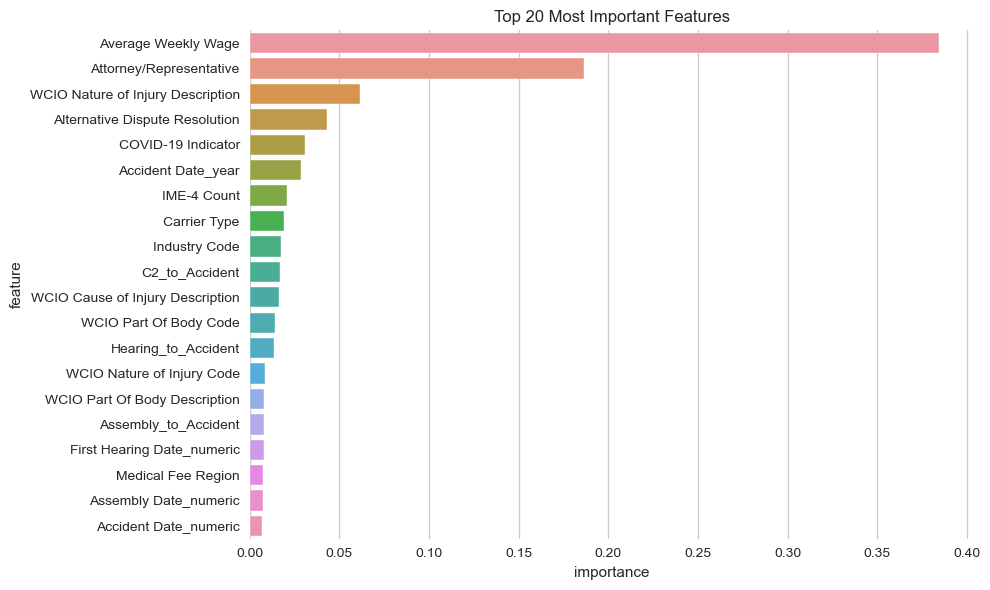


Top 10 Most Important Features:
                              feature  importance
3                 Average Weekly Wage    0.384492
2             Attorney/Representative    0.186289
20  WCIO Nature of Injury Description    0.061732
1      Alternative Dispute Resolution    0.043359
9                  COVID-19 Indicator    0.031154
26                 Accident Date_year    0.028563
12                        IME-4 Count    0.021135
6                        Carrier Type    0.019055
13                      Industry Code    0.017484
46                     C2_to_Accident    0.017111


In [73]:
results, comparison = run_multiple_experiments(train_df_model, test_df_model, experiments)

# Get best model results
best_experiment = comparison.iloc[0]['experiment']
best_model = results[best_experiment]['model']

# Analyze feature importance
feature_names = results[best_experiment]['feature_names']
importance_df = analyze_feature_importance(best_model, feature_names)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [ ]:
################################################################################################################

In [ ]:
################################################################################################################

In [ ]:
#Coisas diferentes, a não ser usadas

In [ ]:
###############################################################################################################

In [ ]:
###############################################################################################################

In [ ]:
def preprocess_data(df, date_columns, impute_strategy='most_frequent'):
    """
    Preprocesses the data with improved handling of completely missing columns.
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    print(f"Initial shape: {df.shape}")
    
    # Convert date columns to datetime format and replace with numeric values
    for date_column in date_columns:
        if date_column in df.columns:
            df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
            df[f'{date_column}_numeric'] = (df[date_column] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
    
    # Drop original date columns
    df = df.drop(columns=[col for col in date_columns if col in df.columns])
    
    print(f"Shape after date processing: {df.shape}")
    
    # Separate numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Number of numeric columns: {len(numeric_cols)}")
    print(f"Number of categorical columns: {len(categorical_cols)}")
    
    # Handle categorical variables first
    label_encoders = {}
    for column in categorical_cols:
        if column in df.columns:
            # Fill NaN values with a placeholder before encoding
            df[column] = df[column].fillna('MISSING')
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column].astype(str))
            label_encoders[column] = le
    
    # Handle numeric variables
    if impute_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=5)
    else:
        imputer = SimpleImputer(strategy=impute_strategy)
    
    # Identify columns with missing values
    cols_with_missing = [col for col in numeric_cols if col in df.columns and df[col].isnull().any()]
    print(f"Columns with missing values: {cols_with_missing}")
    
    # Handle numeric imputation
    if cols_with_missing:
        # Separate columns with all missing values
        all_missing_cols = [col for col in cols_with_missing if df[col].isnull().all()]
        partial_missing_cols = [col for col in cols_with_missing if col not in all_missing_cols]
        
        print(f"Columns with all missing values: {all_missing_cols}")
        print(f"Columns with partial missing values: {partial_missing_cols}")
        
        # Handle columns with partial missing values
        if partial_missing_cols:
            imputed_values = imputer.fit_transform(df[partial_missing_cols])
            for i, col in enumerate(partial_missing_cols):
                df[col] = imputed_values[:, i]
        
        # Fill columns with all missing values with 0 or another appropriate value
        for col in all_missing_cols:
            df[col] = 0  # or another appropriate default value
    
    print(f"Final shape: {df.shape}")
    return df, label_encoders, imputer


In [ ]:
def feature_engineering(df, feature_set='full'):
    """
    Performs feature engineering with proper date column handling
    """
    df = df.copy()
    
    if feature_set == 'minimal':
        # For minimal feature set, drop the date_numeric columns
        date_numeric_cols = [col for col in df.columns if col.endswith('_numeric')]
        return df.drop(columns=date_numeric_cols)
    
    # Create new feature: Time gap between Accident Date and Assembly Date
    if 'Accident Date_numeric' in df.columns and 'Assembly Date_numeric' in df.columns:
        df['Accident_Assembly_Gap'] = df['Assembly Date_numeric'] - df['Accident Date_numeric']
    
    # Additional time-based features
    if 'Accident Date_numeric' in df.columns and 'C-3 Date_numeric' in df.columns:
        df['C3_to_Accident_Gap'] = df['C-3 Date_numeric'] - df['Accident Date_numeric']
    
    if 'Assembly Date_numeric' in df.columns and 'First Hearing Date_numeric' in df.columns:
        df['FirstHearing_to_Assembly_Gap'] = df['First Hearing Date_numeric'] - df['Assembly Date_numeric']
    
    # Extract year, month, weekday from date numeric columns
    date_numeric_cols = [col for col in df.columns if col.endswith('_numeric')]
    for date_col in date_numeric_cols:
        base_name = date_col.replace('_numeric', '')
        # Convert numeric days to datetime for extraction
        temp_dates = pd.to_datetime('1970-01-01') + pd.to_timedelta(df[date_col].fillna(0), unit='D')
        df[f'{base_name}_year'] = temp_dates.dt.year
        df[f'{base_name}_month'] = temp_dates.dt.month
        df[f'{base_name}_weekday'] = temp_dates.dt.weekday
    
    # Create binned categories for continuous variables
    if 'Age at Injury' in df.columns:
        df['Age_at_Injury_Binned'] = pd.cut(df['Age at Injury'], 
                                          bins=[0, 18, 30, 50, 70, 100], 
                                          labels=False)
    
    if 'Average Weekly Wage' in df.columns:
        df['Average_Weekly_Wage_Binned'] = pd.cut(df['Average Weekly Wage'], 
                                                bins=[0, 500, 1000, 1500, 2000, 5000], 
                                                labels=False)
    
    # Create interaction features
    if 'Carrier Type' in df.columns and 'District Name' in df.columns:
        df['CarrierType_District'] = df['Carrier Type'].astype(str) + "_" + df['District Name'].astype(str)
    
    if 'Carrier Type' in df.columns and 'Industry Code' in df.columns:
        df['CarrierType_Industry'] = df['Carrier Type'].astype(str) + "_" + df['Industry Code'].astype(str)
    
    # Create indicator columns for missing values
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            df[f'{column}_missing'] = df[column].isnull().astype(int)
    
    # Drop the date_numeric columns after feature creation
    df = df.drop(columns=date_numeric_cols)
    
    print(f"Feature engineering complete. Shape: {df.shape}")
    print("Columns after feature engineering:", df.columns.tolist())
    
    return df

In [ ]:
def feature_selection(df, target_column, irrelevant_features):

    # Create a copy of the DataFrame
    df_cleaned = df.copy()
    
    # Filter irrelevant_features to only include columns that exist in the DataFrame
    existing_irrelevant = [f for f in irrelevant_features if f in df_cleaned.columns]
    print(f"Dropping columns: {existing_irrelevant}")
    
    # Drop the filtered irrelevant features
    if existing_irrelevant:
        df_cleaned = df_cleaned.drop(columns=existing_irrelevant)
    
    # Split into features and target
    if target_column in df_cleaned.columns:
        X = df_cleaned.drop(columns=[target_column])
        y = df_cleaned[target_column]
        print(f"Features shape: {X.shape}")
        print(f"Target shape: {y.shape}")
        return X, y
    else:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame")

In [ ]:
def scale_features(X_train, X_val=None, scaling_strategy='StandardScaler'):
    if scaling_strategy == 'StandardScaler':
        scaler = StandardScaler()
    elif scaling_strategy == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaling_strategy == 'RobustScaler':
        scaler = RobustScaler()
    else:
        raise ValueError("Unsupported scaling strategy")
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val) if X_val is not None else None
    return X_train_scaled, X_val_scaled, scaler

In [ ]:
def build_and_evaluate_model(X_train, y_train, X_val, y_val):
    # Model Building with Hyperparameter Tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    rf_classifier = RandomForestClassifier(random_state=42)
    rf_random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid,
                                          n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random_search.fit(X_train, y_train)
    
    best_rf = rf_random_search.best_estimator_
    y_val_pred = best_rf.predict(X_val)
    
    print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
    print("Accuracy Score:", accuracy_score(y_val, y_val_pred))
    print("Macro F1 Score:", f1_score(y_val, y_val_pred, average='macro'))
    
    return best_rf

In [ ]:
def prepare_test_data(test_df, date_columns, label_encoders, imputer, irrelevant_features, scaler):
    """
    Prepares test data with improved handling of missing columns.
    """
    test_df = test_df.copy()
    print(f"Initial test shape: {test_df.shape}")
    
    # Process date columns
    for date_column in date_columns:
        if date_column in test_df.columns:
            test_df[date_column] = pd.to_datetime(test_df[date_column], errors='coerce')
            test_df[f'{date_column}_numeric'] = (test_df[date_column] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
    
    # Drop original date columns
    test_df = test_df.drop(columns=[col for col in date_columns if col in test_df.columns])
    
    # Apply label encoding to categorical columns
    for column, le in label_encoders.items():
        if column in test_df.columns:
            test_df[column] = test_df[column].fillna('MISSING')
            test_df[column] = le.transform(test_df[column].astype(str))
    
    # Get numeric columns that need imputation
    numeric_cols = test_df.select_dtypes(include=['number']).columns
    cols_with_missing = [col for col in numeric_cols if test_df[col].isnull().any()]
    
    # Handle numeric imputation
    if cols_with_missing:
        # Separate columns with all missing values
        all_missing_cols = [col for col in cols_with_missing if test_df[col].isnull().all()]
        partial_missing_cols = [col for col in cols_with_missing if col not in all_missing_cols]
        
        # Handle columns with partial missing values
        if partial_missing_cols:
            test_df[partial_missing_cols] = imputer.transform(test_df[partial_missing_cols])
        
        # Fill columns with all missing values with 0 or another appropriate value
        for col in all_missing_cols:
            test_df[col] = 0  # or another appropriate default value
    
    # Drop irrelevant features
    features_to_drop = [f for f in irrelevant_features if f in test_df.columns]
    X_test = test_df.drop(columns=features_to_drop)
    
    print(f"Features shape before scaling: {X_test.shape}")
    X_test_scaled = scaler.transform(X_test)
    
    return X_test_scaled



In [ ]:
# Preprocessing
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

# Estrategias diferentes........
impute_strategies = ['mean', 'median', 'most_frequent', 'knn']
feature_sets = ['full', 'minimal']
scaling_strategies = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']

In [ ]:
def process_data_variants(train_df, test_df, date_columns, impute_strategies, feature_sets, scaling_strategies):

    results = []
    
    # Update irrelevant features list - remove 'Claim Injury Type' since it's already dropped
    irrelevant_features = ['Claim Identifier', 'Zip Code', 'OIICS Nature of Injury Description']
    
    for impute_strategy, feature_set, scaling_strategy in product(impute_strategies, feature_sets, scaling_strategies):
        try:
            variant_name = f"{impute_strategy}_{feature_set}_{scaling_strategy}"
            print(f"\nProcessing with Variant: {variant_name}")
            print("-" * 50)
            
            # Preprocessing with debugging info
            print("Starting preprocessing...")
            train_df_imputed, label_encoders, imputer = preprocess_data(train_df, date_columns, impute_strategy=impute_strategy)
            print("\nColumns after preprocessing:", train_df_imputed.columns.tolist())
            
            # Feature Engineering
            print("\nStarting feature engineering...")
            train_df_fe = feature_engineering(train_df_imputed, feature_set=feature_set)
            print("\nColumns after feature engineering:", train_df_fe.columns.tolist())
            
            # Feature Selection
            print("\nStarting feature selection...")
            X, y = feature_selection(train_df_fe, target_column='Claim Injury Type Num', irrelevant_features=irrelevant_features)
            print(f"Features shape after selection: {X.shape}")
            
            # Train-Test Split
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Scaling Features
            print("Scaling features...")
            X_train_scaled, X_val_scaled, scaler = scale_features(X_train, X_val, scaling_strategy=scaling_strategy)
            
            # Model Building and Evaluation
            print("Building and evaluating model...")
            rf_classifier = build_and_evaluate_model(X_train_scaled, y_train, X_val_scaled, y_val)
            
            # Prepare test data and make predictions
            print("Preparing test data...")
            X_test_scaled = prepare_test_data(test_df, date_columns, label_encoders, imputer, irrelevant_features, scaler)
            y_test_pred = rf_classifier.predict(X_test_scaled)
            
            # Creating Submission File
            submission = pd.DataFrame({
                'Claim Identifier': test_df['Claim Identifier'],
                'Claim Injury Type': y_test_pred
            })
            submission_filename = f'./sample_submission_{variant_name}.csv'
            submission.to_csv(submission_filename, index=False)
            
            # Store results
            results.append({
                'variant': variant_name,
                'accuracy': accuracy_score(y_val, rf_classifier.predict(X_val_scaled)),
                'f1_macro': f1_score(y_val, rf_classifier.predict(X_val_scaled), average='macro')
            })
            
            print(f"Successfully completed variant: {variant_name}")
            
        except Exception as e:
            print(f"Error processing variant {variant_name}:")
            print(f"Error type: {type(e).__name__}")
            print(f"Error message: {str(e)}")
            print("Full traceback:")
            import traceback
            traceback.print_exc()
            continue
    
    return pd.DataFrame(results)

In [ ]:
# Define parameters
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
impute_strategies = ['mean', 'median', 'most_frequent', 'knn']
feature_sets = ['full', 'minimal']
scaling_strategies = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']

# Process all variants with detailed logging
results_df = process_data_variants(
    train_df, 
    test_df, 
    date_columns, 
    impute_strategies, 
    feature_sets, 
    scaling_strategies
)

# View detailed results
print("\nResults Summary:")
print(results_df.sort_values('f1_macro', ascending=False))

In [ ]:
#As ultimas linhas do código não estão a ser usadas, volta para cima :D